In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import sys
import pydot

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from IPython.display import SVG
from keras.utils import plot_model
from keras import optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC
from keras.layers import Lambda,Reshape,Input,Embedding,Dense,Flatten,Activation,concatenate,dot,add,multiply,subtract,Dropout
from keras.models import Model
from tensorflow.keras.preprocessing import sequence
from keras.layers.advanced_activations import PReLU,ReLU
from keras.regularizers import l2 as l2_reg
from sklearn.preprocessing import LabelEncoder,StandardScaler
from keras import backend as K

Using TensorFlow backend.


In [2]:
#train = pd.read_csv('train_merge_data.csv', index_col=0)
#test = pd.read_csv('test_merge_data.csv',index_col=0)
Train = pd.read_csv('train_job/train.csv')
Test = pd.read_csv('test_job.csv')
tags = pd.read_csv('train_job/tags.csv')
user_tags = pd.read_csv('train_job/user_tags.csv')
job_tags = pd.read_csv('train_job/job_tags.csv')
company = pd.read_csv('train_job/job_companies.csv')

In [3]:
data = pd.concat([Test,Train.drop(columns='applied')])

In [4]:
company.companySize.fillna('?',inplace=True)

In [5]:
Train.head(3)

,userID,jobID,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,0
1,6377fa90618fae77571e8dc90d98d409,55b37c5c270e5d84c793e486d798c01d,0
2,8ec0888a5b04139be0dfe942c7eb4199,0fcbc61acd0479dc77e3cccc0f5ffca7,1


In [6]:
Test.head(3)

,userID,jobID
0,ebaee1af0c501f22ddfe242fc16dae53,352407221afb776e3143e8a1a0577885
1,9ab05403ac7808cbfba3da26665f7a9c,96b9bff013acedfb1d140579e2fbeb63
2,33349e909eba71677299d2fc97e158b7,58d4d1e7b1e97b258c9ed0b37e02d087


In [7]:
tags.head(3)

,tagID,keyword
0,602d1305678a8d5fdb372271e980da6a,Amazon Web Services(AWS)
1,e3251075554389fe91d17a794861d47b,Tensorflow
2,a1d50185e7426cbb0acad1e6ca74b9aa,Docker


In [8]:
user_tags.head(3)

,userID,tagID
0,e576423831e043f7928d9ac113abbe6f,82c2559140b95ccda9c6ca4a8b981f1e
1,e576423831e043f7928d9ac113abbe6f,2ba8698b79439589fdd2b0f7218d8b07
2,e576423831e043f7928d9ac113abbe6f,351b33587c5fdd93bd42ef7ac9995a28


In [9]:
job_tags.head(3)

,jobID,tagID
0,320722549d1751cf3f247855f937b982,d38901788c533e8286cb6400b40b386d
1,e744f91c29ec99f0e662c9177946c627,3948ead63a9f2944218de038d8934305
2,e744f91c29ec99f0e662c9177946c627,0e095e054ee94774d6a496099eb1cf6a


In [10]:
jobIDs = data.jobID.unique()
userIDs = data.userID.unique()
tagIDs = tags.tagID.unique()
companyIDs = company.companyID.unique()

jobID_encoder = LabelEncoder(); jobID_encoder.fit(jobIDs)
userID_encoder = LabelEncoder(); userID_encoder.fit(userIDs)
tagID_encoder = LabelEncoder(); tagID_encoder.fit(tagIDs)
companyID_encoder = LabelEncoder(); companyID_encoder.fit(companyIDs)
companySize_encoder = LabelEncoder()

uniq_tagID = tagID_encoder.transform(tagIDs)

company.jobID = jobID_encoder.transform(company.jobID)
company.companyID = companyID_encoder.transform(company.companyID)
company.companySize = companySize_encoder.fit_transform(company.companySize)

user_tags.userID = userID_encoder.transform(user_tags.userID)
user_tags.tagID = tagID_encoder.transform(user_tags.tagID)

job_tags.jobID = jobID_encoder.transform(job_tags.jobID)
job_tags.tagID = tagID_encoder.transform(job_tags.tagID)

def get_userTags(uid):
    return list(user_tags[user_tags.userID==uid].tagID.unique())
def get_jobTags(jid):
    return list(job_tags[job_tags.jobID==jid].tagID.unique())
def get_matchTags(df):
    return np.array(list(set(df.userTags)&set(df.jobTags)))
def get_matchTagsPer(df):
    # user tag중 job tag와 겹치는 tag 비율
    return len(df['matchTags'])/len(set(df.userTags))

def preprocess(df):
    df['userID'] = userID_encoder.transform(df['userID'])
    df['jobID'] = jobID_encoder.transform(df['jobID'])
    df['userTags'] = df.userID.apply(lambda x:get_userTags(x))
    df['jobTags'] = df.jobID.apply(lambda x:get_jobTags(x))
    df['matchTags'] = df.apply(get_matchTags,axis=1)
    df['matchTagsPer'] = df.apply(get_matchTagsPer,axis=1)
    df['anyMatch'] = df['matchTags'].apply(lambda x: 1 if len(x)>0 else 0)
    df = df.merge(company, how='left', on='jobID')
    return df

In [11]:
Train = preprocess(Train)
Test = preprocess(Test)

max_len = 0
for i in pd.concat([Train,Test])['matchTags'].values:
    max_len = max(len(i),max_len)

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [12]:
#user, job 일치하는 tag padding
def pad_matchTags(df):
    pad = df['matchTags'].values
    return sequence.pad_sequences(pad,padding='post')

train_matchTags = pad_matchTags(Train)
test_matchTags = pad_matchTags(Test)

In [13]:
Train.head()

,userID,jobID,applied,userTags,jobTags,matchTags,matchTagsPer,anyMatch,companyID,companySize
0,195,52,0,"[141, 558, 836, 301, 142, 623, 404, 439, 878, ...","[590, 726]",[],0.000000,0,79,3
1,64,245,0,"[836, 485, 501, 439, 205, 640, 282, 42, 510, 8...","[732, 224, 697]",[697],0.040000,1,141,2
2,111,35,1,"[855, 595, 724, 308, 204, 271, 132]","[212, 595, 378]",[595],0.142857,1,259,7
3,190,177,0,"[396, 855, 423, 709, 77, 595, 42, 204, 224, 78...","[42, 780, 439, 709, 366]","[42, 709, 439]",0.176471,1,146,3
4,159,117,0,"[161, 271, 809, 126, 614, 836, 696, 501, 655, ...","[224, 439, 42, 480]",[42],0.050000,1,195,6


In [14]:
COLUMNS = ['userID','jobID','companyID','companySize','matchTagsPer','anyMatch']
CATEGORY = ['userID','jobID','companyID','anyMatch','companySize']
MUL_CATEGORY = ['matchTags']
CONTINUE = ['matchTagsPer']

In [15]:
train_data = Train[COLUMNS]
test_data = Test[COLUMNS]

In [16]:
train_label = np.array(Train['applied'])

In [17]:
# Category / Continue columns encoding
'''
d = pd.concat([train_data,test_data])
for col in CONTINUE:
    scaler = StandardScaler();
    data[col] = scaler.fit_transform(d[[col]])
    train_data[col] = scaler.transform(train_data[[col]])
    test_data[col] = scaler.transform(test_data[[col]])
    
feature_num={}
for col in CATEGORY:
    le = LabelEncoder(); 
    data[col] = le.fit_transform(data[col])
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    feature_num[col] = data[col].max()
for col in CONTINUE:
    scaler = StandardScaler(); 
    data[col] = scaler.fit_transform(data[[col]])
    train[col] = scaler.transform(train[[col]])
    test[col] = scaler.transform(test[[col]])
'''

'\nd = pd.concat([train_data,test_data])\nfor col in CONTINUE:\n    scaler = StandardScaler();\n    data[col] = scaler.fit_transform(d[[col]])\n    train_data[col] = scaler.transform(train_data[[col]])\n    test_data[col] = scaler.transform(test_data[[col]])\n'

In [19]:
train_data.head()

,userID,jobID,companyID,companySize,matchTagsPer,anyMatch
0,195,52,79,3,0.000000,0
1,64,245,141,2,0.040000,1
2,111,35,259,7,0.142857,1
3,190,177,146,3,0.176471,1
4,159,117,195,6,0.050000,1


In [20]:
train_matchTags

array([[  0,   0,   0, ...,   0,   0,   0],
       [697,   0,   0, ...,   0,   0,   0],
       [595,   0,   0, ...,   0,   0,   0],
       ...,
       [697, 836,   0, ...,   0,   0,   0],
       [439,   0,   0, ...,   0,   0,   0],
       [440,   0,   0, ...,   0,   0,   0]])

In [21]:
test_data.head(3)

,userID,jobID,companyID,companySize,matchTagsPer,anyMatch
0,180,157,193,3,0.230769,1
1,121,420,168,6,0.083333,1
2,29,252,111,3,0.166667,1


In [22]:
test_matchTags

array([[204, 141, 423, ...,   0,   0,   0],
       [204,   0,   0, ...,   0,   0,   0],
       [ 42,   0,   0, ...,   0,   0,   0],
       ...,
       [202, 836,   0, ...,   0,   0,   0],
       [595,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [23]:
Train.to_csv('preprocessed_Train.csv',index=False)
Test.to_csv('preprocessed_Test.csv',index=False)

In [24]:
train_category = np.array(train_data[CATEGORY])
test_category = np.array(test_data[CATEGORY])
train_continue = np.array(train_data[CONTINUE])
test_continue = np.array(test_data[CONTINUE])

In [25]:
dim = {}
d = pd.concat([Train,Test])
for col in CATEGORY:
    dim[col] = len(d[col].unique())

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [26]:
# test data의 label값이 없어서, 임의로 train/test set 나눔

x_test = Train.sample(frac=0.15,random_state=2021)
x_train = Train.drop(x_test.index)

train_label = np.array(x_train['applied'])
train_category = np.array(x_train[CATEGORY])
train_continue = np.array(x_train[CONTINUE])
train_matchTags = pad_matchTags(x_train)

test_label = np.array(x_test['applied'])
test_category = np.array(x_test[CATEGORY])
test_continue = np.array(x_test[CONTINUE])
test_matchTags = pad_matchTags(x_test)

In [29]:
def DeepFM(k=16,deep_dim=256,flag=False):
    inputs = []
    flattens = []
    
    #2nd order FM
    for col in CATEGORY:
        input_ = Input(shape=(1,), name='2nd_input_'+col, dtype='int32')
        embed_ = Embedding(dim[col], k, input_length=1,W_regularizer=l2_reg(0.001), name='2nd_embed_'+col)(input_)
        flatten_ = Flatten(name='flatten_'+col)(embed_)
        inputs.append(input_)
        flattens.append(flatten_)
        
    if flag:
        input_ = Input(shape=(max_len,),dtype='int32')
        embed_ = Embedding(len(uniq_tagID),k, input_length=max_len)(input_)
        flatten_ = Lambda(lambda x: K.mean(x,axis=1))(embed_) # None * max_len * k -> None * k
        inputs.append(input_)
        flattens.append(flatten_)
    
    sum_embeds = add(flattens)
    sum_square_embeds = multiply([sum_embeds,sum_embeds])
    square_embeds = []
    
    for layer in flattens:
        square_embeds.append(multiply([layer,layer]))
    square_sum_embeds = add(square_embeds)
    subtract_layer = subtract([sum_square_embeds,square_sum_embeds])
    second_order = Lambda(lambda x: x*0.5)(subtract_layer)
    second_order = Dropout(0.9)(second_order)
    
    #1st order FM
    layers = []
    for idx,col in enumerate(CATEGORY):
        embed_ = Embedding(dim[col],1,input_length=1,W_regularizer=l2_reg(0.001),name='1st_embed_'+col)(inputs[idx])
        flatten_ = Flatten(name='1st_flatten_'+col)(embed_)
        layers.append(flatten_)
    
    first_order = add(layers)
    first_odrer = BatchNormalization()(first_order)
    first_order = Dropout(0.9)(first_order)
    
    #deep
    continue_input = Input(shape=(len(CONTINUE),),name='input_continue')
    inputs.append(continue_input)
    continue_dense = Dense(deep_dim, use_bias=False)(continue_input)
    
    deep = concatenate(flattens+[continue_dense])
    deep = ReLU()(deep)
    #deep = PReLU()(deep)
    deep = Dropout(rate=0.6)(deep)
    
    deep = Dense(deep_dim)(deep)
    deep = ReLU()(deep)
    #deep = PReLU()(deep)
    deep = Dropout(rate=0.3)(deep)
    
    deep = Dense(deep_dim)(deep)
    deep = ReLU()(deep)
    #deep = PReLU()(deep)
    deep = Dropout(rate=0.2)(deep)
    
    concat_input = concatenate([first_order,second_order,deep])
    outputs = Dense(1, activation='sigmoid')(concat_input)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = optimizers.SGD(lr=0.01, decay=0, momentum=0.01, nesterov=True)
    
    loss = 'binary_crossentropy'
    model.compile(optimizer=optimizer, loss=loss, metrics=[AUC(name='auc')])
    
    return model

In [40]:
model = DeepFM(k=18,deep_dim=48)

C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(196, 18, input_length=1, name="2nd_embed_userID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(733, 18, input_length=1, name="2nd_embed_jobID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(276, 18, input_length=1, name="2nd_embed_companyID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 18, input_length=1, name="2nd_embed_anyMatch", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: Use

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
2nd_input_userID (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
2nd_input_jobID (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
2nd_input_companyID (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
2nd_input_anyMatch (InputLayer) (None, 1)            0                                            
____________________________________________________________________________________________

re_lu_6 (ReLU)                  (None, 48)           0           dense_7[0][0]                    
__________________________________________________________________________________________________
1st_embed_userID (Embedding)    (None, 1, 1)         196         2nd_input_userID[0][0]           
__________________________________________________________________________________________________
1st_embed_jobID (Embedding)     (None, 1, 1)         733         2nd_input_jobID[0][0]            
__________________________________________________________________________________________________
1st_embed_companyID (Embedding) (None, 1, 1)         276         2nd_input_companyID[0][0]        
__________________________________________________________________________________________________
1st_embed_anyMatch (Embedding)  (None, 1, 1)         2           2nd_input_anyMatch[0][0]         
__________________________________________________________________________________________________
1st_embed_

In [42]:
epochs = 4000
batch_size = 256

checkpoint = ModelCheckpoint(filepath='DeepFM.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)


#train_input = [train_category[:,i] for i in range(train_category.shape[1])]+[train_continue]
train_input = [train_category[:,i] for i in range(train_category.shape[1])]+[train_matchTags]+[train_continue]
hist = model.fit(train_input,train_label,epochs = epochs, batch_size=batch_size,validation_split=0.15, callbacks=[checkpoint,early_stopping])

C:\Users\moon\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\moon\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4335 samples, validate on 765 samples
Epoch 1/4000
4335/4335 [==============================] - ETA: 10s - loss: 0.7088 - auc: 0.45 - ETA: 0s - loss: 0.6972 - auc: 0.5069 - 1s 206us/step - loss: 0.6915 - auc: 0.5023 - val_loss: 0.6701 - val_auc: 0.5436

Epoch 00001: val_loss improved from inf to 0.67009, saving model to DeepFM.h5
Epoch 2/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.6740 - auc: 0.457 - ETA: 0s - loss: 0.6643 - auc: 0.508 - 0s 25us/step - loss: 0.6584 - auc: 0.5079 - val_loss: 0.6377 - val_auc: 0.5377

Epoch 00002: val_loss improved from 0.67009 to 0.63774, saving model to DeepFM.h5
Epoch 3/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.6491 - auc: 0.515 - ETA: 0s - loss: 0.6345 - auc: 0.474 - 0s 25us/step - loss: 0.6286 - auc: 0.4915 - val_loss: 0.6090 - val_auc: 0.5276

Epoch 00003: val_loss improved from 0.63774 to 0.60904, saving model to DeepFM.h5
Epoch 4/4000
4335/4335 [==============================] - ETA: 0s -


Epoch 00028: val_loss improved from 0.43110 to 0.43059, saving model to DeepFM.h5
Epoch 29/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4072 - auc: 0.493 - ETA: 0s - loss: 0.4271 - auc: 0.503 - 0s 21us/step - loss: 0.4369 - auc: 0.4990 - val_loss: 0.4302 - val_auc: 0.5493

Epoch 00029: val_loss improved from 0.43059 to 0.43016, saving model to DeepFM.h5
Epoch 30/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4356 - auc: 0.573 - ETA: 0s - loss: 0.4285 - auc: 0.513 - 0s 22us/step - loss: 0.4371 - auc: 0.4815 - val_loss: 0.4298 - val_auc: 0.5439

Epoch 00030: val_loss improved from 0.43016 to 0.42980, saving model to DeepFM.h5
Epoch 31/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4652 - auc: 0.482 - ETA: 0s - loss: 0.4346 - auc: 0.529 - 0s 22us/step - loss: 0.4344 - auc: 0.5131 - val_loss: 0.4295 - val_auc: 0.5279

Epoch 00031: val_loss improved from 0.42980 to 0.42946, saving model to DeepFM.h5
Epoch 32/4000
4335/4335 [=

4335/4335 [==============================] - ETA: 0s - loss: 0.3808 - auc: 0.559 - ETA: 0s - loss: 0.4431 - auc: 0.507 - 0s 24us/step - loss: 0.4311 - auc: 0.5197 - val_loss: 0.4271 - val_auc: 0.5719

Epoch 00056: val_loss improved from 0.42713 to 0.42708, saving model to DeepFM.h5
Epoch 57/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4738 - auc: 0.459 - ETA: 0s - loss: 0.4323 - auc: 0.486 - 0s 21us/step - loss: 0.4332 - auc: 0.5031 - val_loss: 0.4270 - val_auc: 0.5716

Epoch 00057: val_loss improved from 0.42708 to 0.42704, saving model to DeepFM.h5
Epoch 58/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5008 - auc: 0.522 - ETA: 0s - loss: 0.4226 - auc: 0.521 - 0s 22us/step - loss: 0.4310 - auc: 0.5191 - val_loss: 0.4270 - val_auc: 0.5908

Epoch 00058: val_loss improved from 0.42704 to 0.42700, saving model to DeepFM.h5
Epoch 59/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4360 - auc: 0.558 - ETA: 0s - loss: 0.4281 - a


Epoch 00083: val_loss improved from 0.42606 to 0.42603, saving model to DeepFM.h5
Epoch 84/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4316 - auc: 0.599 - ETA: 0s - loss: 0.4372 - auc: 0.538 - 0s 22us/step - loss: 0.4302 - auc: 0.5272 - val_loss: 0.4260 - val_auc: 0.6192

Epoch 00084: val_loss improved from 0.42603 to 0.42600, saving model to DeepFM.h5
Epoch 85/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4408 - auc: 0.596 - ETA: 0s - loss: 0.4365 - auc: 0.531 - 0s 21us/step - loss: 0.4294 - auc: 0.5392 - val_loss: 0.4260 - val_auc: 0.6180

Epoch 00085: val_loss improved from 0.42600 to 0.42596, saving model to DeepFM.h5
Epoch 86/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4059 - auc: 0.482 - ETA: 0s - loss: 0.4417 - auc: 0.497 - 0s 22us/step - loss: 0.4324 - auc: 0.4989 - val_loss: 0.4259 - val_auc: 0.6159

Epoch 00086: val_loss improved from 0.42596 to 0.42594, saving model to DeepFM.h5
Epoch 87/4000
4335/4335 [=

4335/4335 [==============================] - ETA: 0s - loss: 0.4461 - auc: 0.511 - ETA: 0s - loss: 0.4431 - auc: 0.509 - 0s 23us/step - loss: 0.4308 - auc: 0.5166 - val_loss: 0.4251 - val_auc: 0.6309

Epoch 00111: val_loss improved from 0.42514 to 0.42511, saving model to DeepFM.h5
Epoch 112/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3974 - auc: 0.522 - ETA: 0s - loss: 0.4285 - auc: 0.533 - 0s 22us/step - loss: 0.4291 - auc: 0.5369 - val_loss: 0.4251 - val_auc: 0.6289

Epoch 00112: val_loss improved from 0.42511 to 0.42508, saving model to DeepFM.h5
Epoch 113/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3884 - auc: 0.432 - ETA: 0s - loss: 0.4263 - auc: 0.538 - 0s 22us/step - loss: 0.4291 - auc: 0.5335 - val_loss: 0.4250 - val_auc: 0.6377

Epoch 00113: val_loss improved from 0.42508 to 0.42504, saving model to DeepFM.h5
Epoch 114/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4658 - auc: 0.453 - ETA: 0s - loss: 0.4182 


Epoch 00138: val_loss improved from 0.42424 to 0.42421, saving model to DeepFM.h5
Epoch 139/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4337 - auc: 0.514 - ETA: 0s - loss: 0.4341 - auc: 0.528 - 0s 21us/step - loss: 0.4290 - auc: 0.5312 - val_loss: 0.4242 - val_auc: 0.6475

Epoch 00139: val_loss improved from 0.42421 to 0.42417, saving model to DeepFM.h5
Epoch 140/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4631 - auc: 0.551 - ETA: 0s - loss: 0.4319 - auc: 0.532 - 0s 20us/step - loss: 0.4291 - auc: 0.5277 - val_loss: 0.4241 - val_auc: 0.6421

Epoch 00140: val_loss improved from 0.42417 to 0.42414, saving model to DeepFM.h5
Epoch 141/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3940 - auc: 0.494 - ETA: 0s - loss: 0.4312 - auc: 0.537 - 0s 22us/step - loss: 0.4275 - auc: 0.5452 - val_loss: 0.4241 - val_auc: 0.6446

Epoch 00141: val_loss improved from 0.42414 to 0.42411, saving model to DeepFM.h5
Epoch 142/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4648 - auc: 0.525 - ETA: 0s - loss: 0.4337 - auc: 0.536 - 0s 22us/step - loss: 0.4282 - auc: 0.5340 - val_loss: 0.4233 - val_auc: 0.6498

Epoch 00166: val_loss improved from 0.42335 to 0.42332, saving model to DeepFM.h5
Epoch 167/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4127 - auc: 0.515 - ETA: 0s - loss: 0.4303 - auc: 0.553 - 0s 22us/step - loss: 0.4264 - auc: 0.5567 - val_loss: 0.4233 - val_auc: 0.6506

Epoch 00167: val_loss improved from 0.42332 to 0.42329, saving model to DeepFM.h5
Epoch 168/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4501 - auc: 0.553 - ETA: 0s - loss: 0.4291 - auc: 0.530 - 0s 22us/step - loss: 0.4288 - auc: 0.5302 - val_loss: 0.4233 - val_auc: 0.6466

Epoch 00168: val_loss improved from 0.42329 to 0.42326, saving model to DeepFM.h5
Epoch 169/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3790 - auc: 0.564 - ETA: 0s - loss: 0.4144 


Epoch 00193: val_loss improved from 0.42257 to 0.42254, saving model to DeepFM.h5
Epoch 194/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4217 - auc: 0.542 - ETA: 0s - loss: 0.4298 - auc: 0.549 - 0s 22us/step - loss: 0.4260 - auc: 0.5531 - val_loss: 0.4225 - val_auc: 0.6504

Epoch 00194: val_loss improved from 0.42254 to 0.42251, saving model to DeepFM.h5
Epoch 195/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3939 - auc: 0.566 - ETA: 0s - loss: 0.4133 - auc: 0.559 - 0s 23us/step - loss: 0.4270 - auc: 0.5491 - val_loss: 0.4225 - val_auc: 0.6525

Epoch 00195: val_loss improved from 0.42251 to 0.42248, saving model to DeepFM.h5
Epoch 196/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3928 - auc: 0.502 - ETA: 0s - loss: 0.4295 - auc: 0.509 - 0s 23us/step - loss: 0.4284 - auc: 0.5300 - val_loss: 0.4225 - val_auc: 0.6523

Epoch 00196: val_loss improved from 0.42248 to 0.42245, saving model to DeepFM.h5
Epoch 197/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3617 - auc: 0.539 - ETA: 0s - loss: 0.4135 - auc: 0.563 - 0s 22us/step - loss: 0.4260 - auc: 0.5493 - val_loss: 0.4217 - val_auc: 0.6473

Epoch 00221: val_loss improved from 0.42175 to 0.42172, saving model to DeepFM.h5
Epoch 222/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4409 - auc: 0.548 - ETA: 0s - loss: 0.4233 - auc: 0.568 - 0s 22us/step - loss: 0.4256 - auc: 0.5626 - val_loss: 0.4217 - val_auc: 0.6471

Epoch 00222: val_loss improved from 0.42172 to 0.42169, saving model to DeepFM.h5
Epoch 223/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3988 - auc: 0.565 - ETA: 0s - loss: 0.4256 - auc: 0.556 - 0s 23us/step - loss: 0.4260 - auc: 0.5481 - val_loss: 0.4217 - val_auc: 0.6474

Epoch 00223: val_loss improved from 0.42169 to 0.42166, saving model to DeepFM.h5
Epoch 224/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4511 - auc: 0.586 - ETA: 0s - loss: 0.4180 


Epoch 00248: val_loss improved from 0.42095 to 0.42092, saving model to DeepFM.h5
Epoch 249/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4044 - auc: 0.650 - ETA: 0s - loss: 0.4297 - auc: 0.559 - 0s 25us/step - loss: 0.4242 - auc: 0.5696 - val_loss: 0.4209 - val_auc: 0.6510

Epoch 00249: val_loss improved from 0.42092 to 0.42089, saving model to DeepFM.h5
Epoch 250/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3924 - auc: 0.567 - ETA: 0s - loss: 0.4112 - auc: 0.552 - 0s 24us/step - loss: 0.4253 - auc: 0.5549 - val_loss: 0.4209 - val_auc: 0.6503

Epoch 00250: val_loss improved from 0.42089 to 0.42085, saving model to DeepFM.h5
Epoch 251/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3814 - auc: 0.513 - ETA: 0s - loss: 0.4256 - auc: 0.587 - 0s 25us/step - loss: 0.4231 - auc: 0.5812 - val_loss: 0.4208 - val_auc: 0.6494

Epoch 00251: val_loss improved from 0.42085 to 0.42081, saving model to DeepFM.h5
Epoch 252/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4092 - auc: 0.514 - ETA: 0s - loss: 0.4322 - auc: 0.537 - 0s 24us/step - loss: 0.4265 - auc: 0.5392 - val_loss: 0.4200 - val_auc: 0.6451

Epoch 00276: val_loss improved from 0.42007 to 0.42004, saving model to DeepFM.h5
Epoch 277/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4501 - auc: 0.572 - ETA: 0s - loss: 0.4195 - auc: 0.565 - 0s 22us/step - loss: 0.4234 - auc: 0.5669 - val_loss: 0.4200 - val_auc: 0.6463

Epoch 00277: val_loss improved from 0.42004 to 0.42000, saving model to DeepFM.h5
Epoch 278/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4627 - auc: 0.635 - ETA: 0s - loss: 0.4368 - auc: 0.552 - 0s 21us/step - loss: 0.4246 - auc: 0.5568 - val_loss: 0.4200 - val_auc: 0.6462

Epoch 00278: val_loss improved from 0.42000 to 0.41997, saving model to DeepFM.h5
Epoch 279/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4358 - auc: 0.604 - ETA: 0s - loss: 0.4378 


Epoch 00303: val_loss improved from 0.41926 to 0.41923, saving model to DeepFM.h5
Epoch 304/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3741 - auc: 0.508 - ETA: 0s - loss: 0.4186 - auc: 0.579 - 0s 21us/step - loss: 0.4230 - auc: 0.5718 - val_loss: 0.4192 - val_auc: 0.6508

Epoch 00304: val_loss improved from 0.41923 to 0.41919, saving model to DeepFM.h5
Epoch 305/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4767 - auc: 0.596 - ETA: 0s - loss: 0.4186 - auc: 0.567 - 0s 23us/step - loss: 0.4235 - auc: 0.5643 - val_loss: 0.4192 - val_auc: 0.6528

Epoch 00305: val_loss improved from 0.41919 to 0.41915, saving model to DeepFM.h5
Epoch 306/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5160 - auc: 0.547 - ETA: 0s - loss: 0.4177 - auc: 0.577 - 0s 23us/step - loss: 0.4228 - auc: 0.5777 - val_loss: 0.4191 - val_auc: 0.6521

Epoch 00306: val_loss improved from 0.41915 to 0.41912, saving model to DeepFM.h5
Epoch 307/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4375 - auc: 0.652 - ETA: 0s - loss: 0.4244 - auc: 0.572 - 0s 22us/step - loss: 0.4230 - auc: 0.5744 - val_loss: 0.4183 - val_auc: 0.6558

Epoch 00331: val_loss improved from 0.41835 to 0.41833, saving model to DeepFM.h5
Epoch 332/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3955 - auc: 0.653 - ETA: 0s - loss: 0.4149 - auc: 0.593 - 0s 21us/step - loss: 0.4213 - auc: 0.5917 - val_loss: 0.4183 - val_auc: 0.6547

Epoch 00332: val_loss improved from 0.41833 to 0.41829, saving model to DeepFM.h5
Epoch 333/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4283 - auc: 0.507 - ETA: 0s - loss: 0.4236 - auc: 0.594 - 0s 23us/step - loss: 0.4205 - auc: 0.5985 - val_loss: 0.4183 - val_auc: 0.6526

Epoch 00333: val_loss improved from 0.41829 to 0.41826, saving model to DeepFM.h5
Epoch 334/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4529 - auc: 0.578 - ETA: 0s - loss: 0.4130 


Epoch 00358: val_loss improved from 0.41757 to 0.41754, saving model to DeepFM.h5
Epoch 359/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4330 - auc: 0.451 - ETA: 0s - loss: 0.4194 - auc: 0.545 - 0s 22us/step - loss: 0.4230 - auc: 0.5675 - val_loss: 0.4175 - val_auc: 0.6542

Epoch 00359: val_loss improved from 0.41754 to 0.41752, saving model to DeepFM.h5
Epoch 360/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4667 - auc: 0.524 - ETA: 0s - loss: 0.4201 - auc: 0.571 - 0s 21us/step - loss: 0.4217 - auc: 0.5798 - val_loss: 0.4175 - val_auc: 0.6549

Epoch 00360: val_loss improved from 0.41752 to 0.41748, saving model to DeepFM.h5
Epoch 361/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4231 - auc: 0.627 - ETA: 0s - loss: 0.4209 - auc: 0.584 - 0s 23us/step - loss: 0.4220 - auc: 0.5764 - val_loss: 0.4174 - val_auc: 0.6559

Epoch 00361: val_loss improved from 0.41748 to 0.41745, saving model to DeepFM.h5
Epoch 362/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4492 - auc: 0.602 - ETA: 0s - loss: 0.4237 - auc: 0.585 - 0s 23us/step - loss: 0.4212 - auc: 0.5857 - val_loss: 0.4167 - val_auc: 0.6547

Epoch 00386: val_loss improved from 0.41671 to 0.41668, saving model to DeepFM.h5
Epoch 387/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4012 - auc: 0.573 - ETA: 0s - loss: 0.4249 - auc: 0.596 - 0s 24us/step - loss: 0.4206 - auc: 0.5926 - val_loss: 0.4167 - val_auc: 0.6527

Epoch 00387: val_loss improved from 0.41668 to 0.41666, saving model to DeepFM.h5
Epoch 388/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4506 - auc: 0.600 - ETA: 0s - loss: 0.4201 - auc: 0.594 - 0s 24us/step - loss: 0.4213 - auc: 0.5814 - val_loss: 0.4166 - val_auc: 0.6544

Epoch 00388: val_loss improved from 0.41666 to 0.41663, saving model to DeepFM.h5
Epoch 389/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4251 - auc: 0.636 - ETA: 0s - loss: 0.4210 


Epoch 00413: val_loss improved from 0.41589 to 0.41586, saving model to DeepFM.h5
Epoch 414/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4612 - auc: 0.536 - ETA: 0s - loss: 0.4179 - auc: 0.583 - 0s 21us/step - loss: 0.4211 - auc: 0.5872 - val_loss: 0.4158 - val_auc: 0.6531

Epoch 00414: val_loss improved from 0.41586 to 0.41583, saving model to DeepFM.h5
Epoch 415/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4312 - auc: 0.632 - ETA: 0s - loss: 0.4237 - auc: 0.602 - 0s 22us/step - loss: 0.4203 - auc: 0.5886 - val_loss: 0.4158 - val_auc: 0.6516

Epoch 00415: val_loss improved from 0.41583 to 0.41580, saving model to DeepFM.h5
Epoch 416/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4289 - auc: 0.569 - ETA: 0s - loss: 0.4231 - auc: 0.594 - 0s 23us/step - loss: 0.4211 - auc: 0.5818 - val_loss: 0.4158 - val_auc: 0.6512

Epoch 00416: val_loss improved from 0.41580 to 0.41577, saving model to DeepFM.h5
Epoch 417/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4788 - auc: 0.594 - ETA: 0s - loss: 0.4159 - auc: 0.595 - 0s 23us/step - loss: 0.4188 - auc: 0.5987 - val_loss: 0.4150 - val_auc: 0.6540

Epoch 00441: val_loss improved from 0.41500 to 0.41496, saving model to DeepFM.h5
Epoch 442/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4863 - auc: 0.552 - ETA: 0s - loss: 0.4281 - auc: 0.591 - 0s 22us/step - loss: 0.4195 - auc: 0.5930 - val_loss: 0.4149 - val_auc: 0.6542

Epoch 00442: val_loss improved from 0.41496 to 0.41494, saving model to DeepFM.h5
Epoch 443/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4471 - auc: 0.612 - ETA: 0s - loss: 0.4267 - auc: 0.576 - 0s 22us/step - loss: 0.4210 - auc: 0.5756 - val_loss: 0.4149 - val_auc: 0.6538

Epoch 00443: val_loss improved from 0.41494 to 0.41491, saving model to DeepFM.h5
Epoch 444/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4030 - auc: 0.741 - ETA: 0s - loss: 0.4180 


Epoch 00468: val_loss improved from 0.41421 to 0.41419, saving model to DeepFM.h5
Epoch 469/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3430 - auc: 0.662 - ETA: 0s - loss: 0.4124 - auc: 0.619 - 0s 22us/step - loss: 0.4166 - auc: 0.6156 - val_loss: 0.4142 - val_auc: 0.6513

Epoch 00469: val_loss improved from 0.41419 to 0.41415, saving model to DeepFM.h5
Epoch 470/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4624 - auc: 0.549 - ETA: 0s - loss: 0.4213 - auc: 0.634 - 0s 24us/step - loss: 0.4159 - auc: 0.6291 - val_loss: 0.4141 - val_auc: 0.6539

Epoch 00470: val_loss improved from 0.41415 to 0.41411, saving model to DeepFM.h5
Epoch 471/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3994 - auc: 0.609 - ETA: 0s - loss: 0.4146 - auc: 0.597 - 0s 22us/step - loss: 0.4185 - auc: 0.6027 - val_loss: 0.4141 - val_auc: 0.6542

Epoch 00471: val_loss improved from 0.41411 to 0.41409, saving model to DeepFM.h5
Epoch 472/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4277 - auc: 0.635 - ETA: 0s - loss: 0.4407 - auc: 0.619 - 0s 27us/step - loss: 0.4154 - auc: 0.6200 - val_loss: 0.4133 - val_auc: 0.6553

Epoch 00496: val_loss improved from 0.41338 to 0.41335, saving model to DeepFM.h5
Epoch 497/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3973 - auc: 0.633 - ETA: 0s - loss: 0.4177 - auc: 0.588 - 0s 29us/step - loss: 0.4191 - auc: 0.5891 - val_loss: 0.4133 - val_auc: 0.6549

Epoch 00497: val_loss improved from 0.41335 to 0.41333, saving model to DeepFM.h5
Epoch 498/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3596 - auc: 0.650 - ETA: 0s - loss: 0.4105 - auc: 0.615 - 0s 28us/step - loss: 0.4167 - auc: 0.6098 - val_loss: 0.4133 - val_auc: 0.6547

Epoch 00498: val_loss improved from 0.41333 to 0.41329, saving model to DeepFM.h5
Epoch 499/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3972 - auc: 0.496 - ETA: 0s - loss: 0.4113 


Epoch 00523: val_loss improved from 0.41257 to 0.41253, saving model to DeepFM.h5
Epoch 524/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3851 - auc: 0.641 - ETA: 0s - loss: 0.4168 - auc: 0.599 - 0s 22us/step - loss: 0.4177 - auc: 0.6003 - val_loss: 0.4125 - val_auc: 0.6531

Epoch 00524: val_loss improved from 0.41253 to 0.41250, saving model to DeepFM.h5
Epoch 525/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3733 - auc: 0.554 - ETA: 0s - loss: 0.4139 - auc: 0.607 - 0s 22us/step - loss: 0.4175 - auc: 0.5989 - val_loss: 0.4125 - val_auc: 0.6533

Epoch 00525: val_loss improved from 0.41250 to 0.41248, saving model to DeepFM.h5
Epoch 526/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4115 - auc: 0.707 - ETA: 0s - loss: 0.4115 - auc: 0.607 - 0s 21us/step - loss: 0.4157 - auc: 0.6129 - val_loss: 0.4124 - val_auc: 0.6540

Epoch 00526: val_loss improved from 0.41248 to 0.41245, saving model to DeepFM.h5
Epoch 527/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3967 - auc: 0.721 - ETA: 0s - loss: 0.4093 - auc: 0.626 - 0s 22us/step - loss: 0.4144 - auc: 0.6237 - val_loss: 0.4116 - val_auc: 0.6591

Epoch 00551: val_loss improved from 0.41167 to 0.41163, saving model to DeepFM.h5
Epoch 552/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3688 - auc: 0.566 - ETA: 0s - loss: 0.4193 - auc: 0.617 - 0s 20us/step - loss: 0.4149 - auc: 0.6175 - val_loss: 0.4116 - val_auc: 0.6587

Epoch 00552: val_loss improved from 0.41163 to 0.41160, saving model to DeepFM.h5
Epoch 553/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4018 - auc: 0.634 - ETA: 0s - loss: 0.4118 - auc: 0.632 - 0s 23us/step - loss: 0.4144 - auc: 0.6203 - val_loss: 0.4116 - val_auc: 0.6584

Epoch 00553: val_loss improved from 0.41160 to 0.41157, saving model to DeepFM.h5
Epoch 554/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4037 - auc: 0.655 - ETA: 0s - loss: 0.4170 


Epoch 00578: val_loss improved from 0.41084 to 0.41080, saving model to DeepFM.h5
Epoch 579/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3546 - auc: 0.708 - ETA: 0s - loss: 0.4098 - auc: 0.644 - 0s 23us/step - loss: 0.4114 - auc: 0.6412 - val_loss: 0.4108 - val_auc: 0.6637

Epoch 00579: val_loss improved from 0.41080 to 0.41075, saving model to DeepFM.h5
Epoch 580/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4276 - auc: 0.589 - ETA: 0s - loss: 0.4103 - auc: 0.616 - 0s 21us/step - loss: 0.4152 - auc: 0.6170 - val_loss: 0.4107 - val_auc: 0.6629

Epoch 00580: val_loss improved from 0.41075 to 0.41073, saving model to DeepFM.h5
Epoch 581/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3383 - auc: 0.640 - ETA: 0s - loss: 0.4061 - auc: 0.629 - 0s 23us/step - loss: 0.4129 - auc: 0.6287 - val_loss: 0.4107 - val_auc: 0.6632

Epoch 00581: val_loss improved from 0.41073 to 0.41069, saving model to DeepFM.h5
Epoch 582/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3823 - auc: 0.619 - ETA: 0s - loss: 0.4123 - auc: 0.611 - 0s 23us/step - loss: 0.4148 - auc: 0.6166 - val_loss: 0.4099 - val_auc: 0.6645

Epoch 00606: val_loss improved from 0.40995 to 0.40993, saving model to DeepFM.h5
Epoch 607/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3984 - auc: 0.649 - ETA: 0s - loss: 0.4148 - auc: 0.611 - 0s 22us/step - loss: 0.4121 - auc: 0.6338 - val_loss: 0.4099 - val_auc: 0.6657

Epoch 00607: val_loss improved from 0.40993 to 0.40989, saving model to DeepFM.h5
Epoch 608/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4442 - auc: 0.656 - ETA: 0s - loss: 0.4188 - auc: 0.623 - 0s 22us/step - loss: 0.4118 - auc: 0.6342 - val_loss: 0.4099 - val_auc: 0.6659

Epoch 00608: val_loss improved from 0.40989 to 0.40986, saving model to DeepFM.h5
Epoch 609/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3647 - auc: 0.597 - ETA: 0s - loss: 0.4084 


Epoch 00633: val_loss improved from 0.40909 to 0.40908, saving model to DeepFM.h5
Epoch 634/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5208 - auc: 0.619 - ETA: 0s - loss: 0.4281 - auc: 0.620 - 0s 21us/step - loss: 0.4116 - auc: 0.6312 - val_loss: 0.4090 - val_auc: 0.6658

Epoch 00634: val_loss improved from 0.40908 to 0.40904, saving model to DeepFM.h5
Epoch 635/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4625 - auc: 0.614 - ETA: 0s - loss: 0.4108 - auc: 0.631 - 0s 23us/step - loss: 0.4107 - auc: 0.6395 - val_loss: 0.4090 - val_auc: 0.6651

Epoch 00635: val_loss improved from 0.40904 to 0.40900, saving model to DeepFM.h5
Epoch 636/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4525 - auc: 0.636 - ETA: 0s - loss: 0.4122 - auc: 0.643 - 0s 22us/step - loss: 0.4101 - auc: 0.6426 - val_loss: 0.4090 - val_auc: 0.6658

Epoch 00636: val_loss improved from 0.40900 to 0.40896, saving model to DeepFM.h5
Epoch 637/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4363 - auc: 0.603 - ETA: 0s - loss: 0.4179 - auc: 0.621 - 0s 22us/step - loss: 0.4111 - auc: 0.6251 - val_loss: 0.4081 - val_auc: 0.6695

Epoch 00661: val_loss improved from 0.40813 to 0.40810, saving model to DeepFM.h5
Epoch 662/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3677 - auc: 0.653 - ETA: 0s - loss: 0.4130 - auc: 0.608 - 0s 23us/step - loss: 0.4142 - auc: 0.6113 - val_loss: 0.4081 - val_auc: 0.6679

Epoch 00662: val_loss improved from 0.40810 to 0.40807, saving model to DeepFM.h5
Epoch 663/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4370 - auc: 0.581 - ETA: 0s - loss: 0.4207 - auc: 0.625 - 0s 22us/step - loss: 0.4120 - auc: 0.6293 - val_loss: 0.4081 - val_auc: 0.6687

Epoch 00663: val_loss improved from 0.40807 to 0.40805, saving model to DeepFM.h5
Epoch 664/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4243 - auc: 0.608 - ETA: 0s - loss: 0.4030 


Epoch 00688: val_loss improved from 0.40727 to 0.40725, saving model to DeepFM.h5
Epoch 689/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4328 - auc: 0.626 - ETA: 0s - loss: 0.4141 - auc: 0.636 - 0s 23us/step - loss: 0.4086 - auc: 0.6471 - val_loss: 0.4072 - val_auc: 0.6712

Epoch 00689: val_loss improved from 0.40725 to 0.40723, saving model to DeepFM.h5
Epoch 690/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3554 - auc: 0.675 - ETA: 0s - loss: 0.4083 - auc: 0.649 - 0s 21us/step - loss: 0.4078 - auc: 0.6448 - val_loss: 0.4072 - val_auc: 0.6707

Epoch 00690: val_loss improved from 0.40723 to 0.40721, saving model to DeepFM.h5
Epoch 691/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4009 - auc: 0.625 - ETA: 0s - loss: 0.3946 - auc: 0.653 - 0s 23us/step - loss: 0.4095 - auc: 0.6467 - val_loss: 0.4072 - val_auc: 0.6707

Epoch 00691: val_loss improved from 0.40721 to 0.40718, saving model to DeepFM.h5
Epoch 692/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4291 - auc: 0.671 - ETA: 0s - loss: 0.4017 - auc: 0.640 - 0s 22us/step - loss: 0.4081 - auc: 0.6444 - val_loss: 0.4063 - val_auc: 0.6719

Epoch 00716: val_loss improved from 0.40632 to 0.40628, saving model to DeepFM.h5
Epoch 717/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4136 - auc: 0.596 - ETA: 0s - loss: 0.4058 - auc: 0.640 - 0s 21us/step - loss: 0.4091 - auc: 0.6444 - val_loss: 0.4063 - val_auc: 0.6721

Epoch 00717: val_loss improved from 0.40628 to 0.40625, saving model to DeepFM.h5
Epoch 718/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4064 - auc: 0.615 - ETA: 0s - loss: 0.4157 - auc: 0.650 - 0s 22us/step - loss: 0.4073 - auc: 0.6560 - val_loss: 0.4062 - val_auc: 0.6721

Epoch 00718: val_loss improved from 0.40625 to 0.40622, saving model to DeepFM.h5
Epoch 719/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4280 - auc: 0.657 - ETA: 0s - loss: 0.4110 


Epoch 00743: val_loss improved from 0.40544 to 0.40539, saving model to DeepFM.h5
Epoch 744/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3859 - auc: 0.617 - ETA: 0s - loss: 0.4125 - auc: 0.628 - 0s 22us/step - loss: 0.4093 - auc: 0.6425 - val_loss: 0.4053 - val_auc: 0.6735

Epoch 00744: val_loss improved from 0.40539 to 0.40534, saving model to DeepFM.h5
Epoch 745/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4142 - auc: 0.612 - ETA: 0s - loss: 0.4065 - auc: 0.638 - 0s 22us/step - loss: 0.4077 - auc: 0.6485 - val_loss: 0.4053 - val_auc: 0.6729

Epoch 00745: val_loss improved from 0.40534 to 0.40530, saving model to DeepFM.h5
Epoch 746/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4581 - auc: 0.667 - ETA: 0s - loss: 0.4046 - auc: 0.649 - 0s 21us/step - loss: 0.4083 - auc: 0.6470 - val_loss: 0.4053 - val_auc: 0.6729

Epoch 00746: val_loss improved from 0.40530 to 0.40526, saving model to DeepFM.h5
Epoch 747/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4366 - auc: 0.596 - ETA: 0s - loss: 0.4022 - auc: 0.657 - 0s 22us/step - loss: 0.4065 - auc: 0.6523 - val_loss: 0.4044 - val_auc: 0.6786

Epoch 00771: val_loss improved from 0.40442 to 0.40438, saving model to DeepFM.h5
Epoch 772/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3923 - auc: 0.641 - ETA: 0s - loss: 0.4035 - auc: 0.634 - 0s 22us/step - loss: 0.4076 - auc: 0.6489 - val_loss: 0.4044 - val_auc: 0.6775

Epoch 00772: val_loss improved from 0.40438 to 0.40436, saving model to DeepFM.h5
Epoch 773/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4328 - auc: 0.506 - ETA: 0s - loss: 0.4021 - auc: 0.649 - 0s 24us/step - loss: 0.4075 - auc: 0.6512 - val_loss: 0.4043 - val_auc: 0.6779

Epoch 00773: val_loss improved from 0.40436 to 0.40434, saving model to DeepFM.h5
Epoch 774/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4089 - auc: 0.632 - ETA: 0s - loss: 0.4166 


Epoch 00798: val_loss improved from 0.40345 to 0.40343, saving model to DeepFM.h5
Epoch 799/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4087 - auc: 0.668 - ETA: 0s - loss: 0.4089 - auc: 0.636 - 0s 23us/step - loss: 0.4087 - auc: 0.6370 - val_loss: 0.4034 - val_auc: 0.6807

Epoch 00799: val_loss improved from 0.40343 to 0.40339, saving model to DeepFM.h5
Epoch 800/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4320 - auc: 0.591 - ETA: 0s - loss: 0.4089 - auc: 0.659 - 0s 21us/step - loss: 0.4032 - auc: 0.6664 - val_loss: 0.4033 - val_auc: 0.6821

Epoch 00800: val_loss improved from 0.40339 to 0.40332, saving model to DeepFM.h5
Epoch 801/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4482 - auc: 0.673 - ETA: 0s - loss: 0.3987 - auc: 0.653 - 0s 22us/step - loss: 0.4033 - auc: 0.6696 - val_loss: 0.4033 - val_auc: 0.6823

Epoch 00801: val_loss improved from 0.40332 to 0.40329, saving model to DeepFM.h5
Epoch 802/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4100 - auc: 0.758 - ETA: 0s - loss: 0.3989 - auc: 0.689 - 0s 22us/step - loss: 0.4020 - auc: 0.6756 - val_loss: 0.4024 - val_auc: 0.6840

Epoch 00826: val_loss improved from 0.40240 to 0.40240, saving model to DeepFM.h5
Epoch 827/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4365 - auc: 0.704 - ETA: 0s - loss: 0.4010 - auc: 0.681 - 0s 23us/step - loss: 0.4029 - auc: 0.6735 - val_loss: 0.4024 - val_auc: 0.6824

Epoch 00827: val_loss improved from 0.40240 to 0.40239, saving model to DeepFM.h5
Epoch 828/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3768 - auc: 0.683 - ETA: 0s - loss: 0.3878 - auc: 0.679 - 0s 21us/step - loss: 0.4035 - auc: 0.6698 - val_loss: 0.4023 - val_auc: 0.6839

Epoch 00828: val_loss improved from 0.40239 to 0.40229, saving model to DeepFM.h5
Epoch 829/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3924 - auc: 0.713 - ETA: 0s - loss: 0.4022 


Epoch 00853: val_loss improved from 0.40133 to 0.40128, saving model to DeepFM.h5
Epoch 854/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5146 - auc: 0.611 - ETA: 0s - loss: 0.4055 - auc: 0.656 - 0s 22us/step - loss: 0.4033 - auc: 0.6670 - val_loss: 0.4013 - val_auc: 0.6859

Epoch 00854: val_loss improved from 0.40128 to 0.40125, saving model to DeepFM.h5
Epoch 855/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3527 - auc: 0.659 - ETA: 0s - loss: 0.4015 - auc: 0.655 - 0s 22us/step - loss: 0.4021 - auc: 0.6676 - val_loss: 0.4012 - val_auc: 0.6852

Epoch 00855: val_loss improved from 0.40125 to 0.40120, saving model to DeepFM.h5
Epoch 856/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4705 - auc: 0.657 - ETA: 0s - loss: 0.4027 - auc: 0.668 - 0s 23us/step - loss: 0.4046 - auc: 0.6637 - val_loss: 0.4012 - val_auc: 0.6849

Epoch 00856: val_loss improved from 0.40120 to 0.40116, saving model to DeepFM.h5
Epoch 857/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4143 - auc: 0.672 - ETA: 0s - loss: 0.3942 - auc: 0.684 - 0s 22us/step - loss: 0.4004 - auc: 0.6760 - val_loss: 0.4001 - val_auc: 0.6902

Epoch 00881: val_loss improved from 0.40017 to 0.40011, saving model to DeepFM.h5
Epoch 882/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3688 - auc: 0.703 - ETA: 0s - loss: 0.4013 - auc: 0.676 - 0s 22us/step - loss: 0.3985 - auc: 0.6825 - val_loss: 0.4001 - val_auc: 0.6898

Epoch 00882: val_loss improved from 0.40011 to 0.40008, saving model to DeepFM.h5
Epoch 883/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3641 - auc: 0.672 - ETA: 0s - loss: 0.3987 - auc: 0.683 - 0s 22us/step - loss: 0.4003 - auc: 0.6796 - val_loss: 0.4000 - val_auc: 0.6897

Epoch 00883: val_loss improved from 0.40008 to 0.40002, saving model to DeepFM.h5
Epoch 884/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3699 - auc: 0.745 - ETA: 0s - loss: 0.3956 


Epoch 00908: val_loss improved from 0.39905 to 0.39901, saving model to DeepFM.h5
Epoch 909/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3612 - auc: 0.694 - ETA: 0s - loss: 0.3919 - auc: 0.715 - 0s 20us/step - loss: 0.3964 - auc: 0.6899 - val_loss: 0.3989 - val_auc: 0.6928

Epoch 00909: val_loss improved from 0.39901 to 0.39893, saving model to DeepFM.h5
Epoch 910/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3788 - auc: 0.712 - ETA: 0s - loss: 0.4080 - auc: 0.673 - 0s 22us/step - loss: 0.3993 - auc: 0.6873 - val_loss: 0.3989 - val_auc: 0.6926

Epoch 00910: val_loss improved from 0.39893 to 0.39887, saving model to DeepFM.h5
Epoch 911/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4106 - auc: 0.631 - ETA: 0s - loss: 0.3950 - auc: 0.668 - 0s 25us/step - loss: 0.3995 - auc: 0.6771 - val_loss: 0.3988 - val_auc: 0.6927

Epoch 00911: val_loss improved from 0.39887 to 0.39882, saving model to DeepFM.h5
Epoch 912/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4601 - auc: 0.612 - ETA: 0s - loss: 0.3978 - auc: 0.691 - 0s 23us/step - loss: 0.3975 - auc: 0.6887 - val_loss: 0.3976 - val_auc: 0.6953

Epoch 00936: val_loss improved from 0.39769 to 0.39765, saving model to DeepFM.h5
Epoch 937/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4017 - auc: 0.626 - ETA: 0s - loss: 0.3874 - auc: 0.695 - 0s 22us/step - loss: 0.3947 - auc: 0.7010 - val_loss: 0.3976 - val_auc: 0.6961

Epoch 00937: val_loss improved from 0.39765 to 0.39758, saving model to DeepFM.h5
Epoch 938/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3793 - auc: 0.733 - ETA: 0s - loss: 0.3894 - auc: 0.694 - 0s 22us/step - loss: 0.3948 - auc: 0.6995 - val_loss: 0.3975 - val_auc: 0.6945

Epoch 00938: val_loss improved from 0.39758 to 0.39750, saving model to DeepFM.h5
Epoch 939/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4163 - auc: 0.734 - ETA: 0s - loss: 0.3942 


Epoch 00963: val_loss improved from 0.39626 to 0.39618, saving model to DeepFM.h5
Epoch 964/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4719 - auc: 0.634 - ETA: 0s - loss: 0.3946 - auc: 0.698 - 0s 20us/step - loss: 0.3935 - auc: 0.7006 - val_loss: 0.3962 - val_auc: 0.7000

Epoch 00964: val_loss improved from 0.39618 to 0.39616, saving model to DeepFM.h5
Epoch 965/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4293 - auc: 0.723 - ETA: 0s - loss: 0.4098 - auc: 0.695 - 0s 21us/step - loss: 0.3950 - auc: 0.6991 - val_loss: 0.3961 - val_auc: 0.7007

Epoch 00965: val_loss improved from 0.39616 to 0.39611, saving model to DeepFM.h5
Epoch 966/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3696 - auc: 0.683 - ETA: 0s - loss: 0.3972 - auc: 0.692 - 0s 22us/step - loss: 0.3948 - auc: 0.6970 - val_loss: 0.3960 - val_auc: 0.7008

Epoch 00966: val_loss improved from 0.39611 to 0.39603, saving model to DeepFM.h5
Epoch 967/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3873 - auc: 0.739 - ETA: 0s - loss: 0.3836 - auc: 0.708 - 0s 23us/step - loss: 0.3911 - auc: 0.7132 - val_loss: 0.3947 - val_auc: 0.7036

Epoch 00991: val_loss improved from 0.39480 to 0.39475, saving model to DeepFM.h5
Epoch 992/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3503 - auc: 0.702 - ETA: 0s - loss: 0.3880 - auc: 0.706 - 0s 23us/step - loss: 0.3903 - auc: 0.7170 - val_loss: 0.3947 - val_auc: 0.7045

Epoch 00992: val_loss improved from 0.39475 to 0.39471, saving model to DeepFM.h5
Epoch 993/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3609 - auc: 0.688 - ETA: 0s - loss: 0.3921 - auc: 0.718 - 0s 22us/step - loss: 0.3943 - auc: 0.6983 - val_loss: 0.3946 - val_auc: 0.7043

Epoch 00993: val_loss improved from 0.39471 to 0.39462, saving model to DeepFM.h5
Epoch 994/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3602 - auc: 0.616 - ETA: 0s - loss: 0.3892 


Epoch 01018: val_loss improved from 0.39322 to 0.39320, saving model to DeepFM.h5
Epoch 1019/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4029 - auc: 0.745 - ETA: 0s - loss: 0.3918 - auc: 0.719 - 0s 23us/step - loss: 0.3880 - auc: 0.7263 - val_loss: 0.3932 - val_auc: 0.7103

Epoch 01019: val_loss improved from 0.39320 to 0.39315, saving model to DeepFM.h5
Epoch 1020/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3381 - auc: 0.750 - ETA: 0s - loss: 0.3862 - auc: 0.717 - 0s 24us/step - loss: 0.3891 - auc: 0.7220 - val_loss: 0.3930 - val_auc: 0.7096

Epoch 01020: val_loss improved from 0.39315 to 0.39304, saving model to DeepFM.h5
Epoch 1021/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3945 - auc: 0.702 - ETA: 0s - loss: 0.3942 - auc: 0.719 - 0s 22us/step - loss: 0.3911 - auc: 0.7154 - val_loss: 0.3930 - val_auc: 0.7105

Epoch 01021: val_loss improved from 0.39304 to 0.39301, saving model to DeepFM.h5
Epoch 1022/4000
4335

4335/4335 [==============================] - ETA: 0s - loss: 0.4647 - auc: 0.671 - ETA: 0s - loss: 0.3982 - auc: 0.710 - 0s 21us/step - loss: 0.3905 - auc: 0.7128 - val_loss: 0.3915 - val_auc: 0.7146

Epoch 01046: val_loss improved from 0.39146 to 0.39145, saving model to DeepFM.h5
Epoch 1047/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3247 - auc: 0.731 - ETA: 0s - loss: 0.3848 - auc: 0.716 - 0s 23us/step - loss: 0.3887 - auc: 0.7231 - val_loss: 0.3913 - val_auc: 0.7148

Epoch 01047: val_loss improved from 0.39145 to 0.39134, saving model to DeepFM.h5
Epoch 1048/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3557 - auc: 0.740 - ETA: 0s - loss: 0.3879 - auc: 0.720 - 0s 24us/step - loss: 0.3885 - auc: 0.7219 - val_loss: 0.3913 - val_auc: 0.7142

Epoch 01048: val_loss improved from 0.39134 to 0.39130, saving model to DeepFM.h5
Epoch 1049/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3487 - auc: 0.787 - ETA: 0s - loss: 0.37


Epoch 01073: val_loss improved from 0.38980 to 0.38978, saving model to DeepFM.h5
Epoch 1074/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4335 - auc: 0.733 - ETA: 0s - loss: 0.3875 - auc: 0.718 - 0s 22us/step - loss: 0.3881 - auc: 0.7165 - val_loss: 0.3897 - val_auc: 0.7200

Epoch 01074: val_loss improved from 0.38978 to 0.38972, saving model to DeepFM.h5
Epoch 1075/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4078 - auc: 0.733 - ETA: 0s - loss: 0.3873 - auc: 0.729 - 0s 22us/step - loss: 0.3861 - auc: 0.7258 - val_loss: 0.3896 - val_auc: 0.7205

Epoch 01075: val_loss improved from 0.38972 to 0.38961, saving model to DeepFM.h5
Epoch 1076/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4138 - auc: 0.746 - ETA: 0s - loss: 0.3931 - auc: 0.720 - 0s 23us/step - loss: 0.3850 - auc: 0.7316 - val_loss: 0.3895 - val_auc: 0.7208

Epoch 01076: val_loss improved from 0.38961 to 0.38955, saving model to DeepFM.h5
Epoch 1077/4000
4335

4335/4335 [==============================] - ETA: 0s - loss: 0.3329 - auc: 0.770 - ETA: 0s - loss: 0.3850 - auc: 0.737 - 0s 21us/step - loss: 0.3841 - auc: 0.7338 - val_loss: 0.3878 - val_auc: 0.7265

Epoch 01101: val_loss improved from 0.38778 to 0.38778, saving model to DeepFM.h5
Epoch 1102/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4394 - auc: 0.748 - ETA: 0s - loss: 0.3884 - auc: 0.727 - 0s 22us/step - loss: 0.3826 - auc: 0.7302 - val_loss: 0.3877 - val_auc: 0.7269

Epoch 01102: val_loss improved from 0.38778 to 0.38773, saving model to DeepFM.h5
Epoch 1103/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3758 - auc: 0.750 - ETA: 0s - loss: 0.3770 - auc: 0.731 - 0s 22us/step - loss: 0.3830 - auc: 0.7366 - val_loss: 0.3876 - val_auc: 0.7270

Epoch 01103: val_loss improved from 0.38773 to 0.38761, saving model to DeepFM.h5
Epoch 1104/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4025 - auc: 0.760 - ETA: 0s - loss: 0.37


Epoch 01128: val_loss improved from 0.38586 to 0.38586, saving model to DeepFM.h5
Epoch 1129/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.2876 - auc: 0.735 - ETA: 0s - loss: 0.3856 - auc: 0.735 - 0s 22us/step - loss: 0.3819 - auc: 0.7350 - val_loss: 0.3858 - val_auc: 0.7320

Epoch 01129: val_loss improved from 0.38586 to 0.38575, saving model to DeepFM.h5
Epoch 1130/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4102 - auc: 0.747 - ETA: 0s - loss: 0.3912 - auc: 0.735 - 0s 22us/step - loss: 0.3782 - auc: 0.7440 - val_loss: 0.3858 - val_auc: 0.7308

Epoch 01130: val_loss did not improve from 0.38575
Epoch 1131/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3554 - auc: 0.752 - ETA: 0s - loss: 0.3916 - auc: 0.726 - 0s 23us/step - loss: 0.3839 - auc: 0.7280 - val_loss: 0.3857 - val_auc: 0.7311

Epoch 01131: val_loss improved from 0.38575 to 0.38571, saving model to DeepFM.h5
Epoch 1132/4000
4335/4335 [========================

4335/4335 [==============================] - ETA: 0s - loss: 0.3826 - auc: 0.784 - ETA: 0s - loss: 0.3848 - auc: 0.747 - 0s 22us/step - loss: 0.3762 - auc: 0.7531 - val_loss: 0.3838 - val_auc: 0.7356

Epoch 01156: val_loss improved from 0.38386 to 0.38382, saving model to DeepFM.h5
Epoch 1157/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3772 - auc: 0.758 - ETA: 0s - loss: 0.3901 - auc: 0.745 - 0s 21us/step - loss: 0.3787 - auc: 0.7479 - val_loss: 0.3838 - val_auc: 0.7364

Epoch 01157: val_loss improved from 0.38382 to 0.38381, saving model to DeepFM.h5
Epoch 1158/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3588 - auc: 0.712 - ETA: 0s - loss: 0.3734 - auc: 0.760 - 0s 23us/step - loss: 0.3766 - auc: 0.7500 - val_loss: 0.3838 - val_auc: 0.7377

Epoch 01158: val_loss improved from 0.38381 to 0.38380, saving model to DeepFM.h5
Epoch 1159/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3740 - auc: 0.842 - ETA: 0s - loss: 0.37

Epoch 01183: val_loss improved from 0.38209 to 0.38194, saving model to DeepFM.h5
Epoch 1184/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3850 - auc: 0.770 - ETA: 0s - loss: 0.3673 - auc: 0.754 - 0s 21us/step - loss: 0.3723 - auc: 0.7605 - val_loss: 0.3818 - val_auc: 0.7408

Epoch 01184: val_loss improved from 0.38194 to 0.38179, saving model to DeepFM.h5
Epoch 1185/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3812 - auc: 0.789 - ETA: 0s - loss: 0.3815 - auc: 0.770 - 0s 22us/step - loss: 0.3704 - auc: 0.7666 - val_loss: 0.3818 - val_auc: 0.7410

Epoch 01185: val_loss improved from 0.38179 to 0.38176, saving model to DeepFM.h5
Epoch 1186/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3581 - auc: 0.754 - ETA: 0s - loss: 0.3609 - auc: 0.777 - 0s 23us/step - loss: 0.3696 - auc: 0.7672 - val_loss: 0.3816 - val_auc: 0.7407

Epoch 01186: val_loss improved from 0.38176 to 0.38164, saving model to DeepFM.h5
Epoch 1187/4000
4335/

4335/4335 [==============================] - ETA: 0s - loss: 0.4394 - auc: 0.775 - ETA: 0s - loss: 0.3797 - auc: 0.762 - 0s 22us/step - loss: 0.3725 - auc: 0.7566 - val_loss: 0.3798 - val_auc: 0.7456

Epoch 01211: val_loss did not improve from 0.37979
Epoch 1212/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3463 - auc: 0.778 - ETA: 0s - loss: 0.3674 - auc: 0.770 - 0s 23us/step - loss: 0.3701 - auc: 0.7662 - val_loss: 0.3797 - val_auc: 0.7449

Epoch 01212: val_loss improved from 0.37979 to 0.37967, saving model to DeepFM.h5
Epoch 1213/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3912 - auc: 0.787 - ETA: 0s - loss: 0.3675 - auc: 0.754 - 0s 21us/step - loss: 0.3703 - auc: 0.7609 - val_loss: 0.3795 - val_auc: 0.7439

Epoch 01213: val_loss improved from 0.37967 to 0.37951, saving model to DeepFM.h5
Epoch 1214/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3468 - auc: 0.727 - ETA: 0s - loss: 0.3721 - auc: 0.764 - 0s 21us/step 

4335/4335 [==============================] - ETA: 0s - loss: 0.4459 - auc: 0.742 - ETA: 0s - loss: 0.3703 - auc: 0.758 - 0s 22us/step - loss: 0.3722 - auc: 0.7659 - val_loss: 0.3775 - val_auc: 0.7504

Epoch 01239: val_loss improved from 0.37753 to 0.37746, saving model to DeepFM.h5
Epoch 1240/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3173 - auc: 0.773 - ETA: 0s - loss: 0.3611 - auc: 0.768 - 0s 21us/step - loss: 0.3683 - auc: 0.7633 - val_loss: 0.3773 - val_auc: 0.7500

Epoch 01240: val_loss improved from 0.37746 to 0.37734, saving model to DeepFM.h5
Epoch 1241/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3488 - auc: 0.781 - ETA: 0s - loss: 0.3715 - auc: 0.753 - 0s 23us/step - loss: 0.3717 - auc: 0.7589 - val_loss: 0.3774 - val_auc: 0.7513

Epoch 01241: val_loss did not improve from 0.37734
Epoch 1242/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3733 - auc: 0.799 - ETA: 0s - loss: 0.3669 - auc: 0.771 - 0s 22us/step 

4335/4335 [==============================] - ETA: 0s - loss: 0.3307 - auc: 0.701 - ETA: 0s - loss: 0.3602 - auc: 0.784 - 0s 22us/step - loss: 0.3678 - auc: 0.7696 - val_loss: 0.3756 - val_auc: 0.7541

Epoch 01267: val_loss improved from 0.37572 to 0.37558, saving model to DeepFM.h5
Epoch 1268/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3806 - auc: 0.773 - ETA: 0s - loss: 0.3626 - auc: 0.775 - 0s 22us/step - loss: 0.3650 - auc: 0.7775 - val_loss: 0.3756 - val_auc: 0.7555

Epoch 01268: val_loss did not improve from 0.37558
Epoch 1269/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4337 - auc: 0.688 - ETA: 0s - loss: 0.3595 - auc: 0.777 - 0s 21us/step - loss: 0.3648 - auc: 0.7744 - val_loss: 0.3755 - val_auc: 0.7547

Epoch 01269: val_loss improved from 0.37558 to 0.37546, saving model to DeepFM.h5
Epoch 1270/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3735 - auc: 0.697 - ETA: 0s - loss: 0.3529 - auc: 0.779 - 0s 21us/step 


Epoch 01295: val_loss did not improve from 0.37381
Epoch 1296/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4019 - auc: 0.755 - ETA: 0s - loss: 0.3552 - auc: 0.783 - 0s 22us/step - loss: 0.3631 - auc: 0.7742 - val_loss: 0.3738 - val_auc: 0.7558

Epoch 01296: val_loss improved from 0.37381 to 0.37379, saving model to DeepFM.h5
Epoch 1297/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.2957 - auc: 0.890 - ETA: 0s - loss: 0.3650 - auc: 0.780 - 0s 21us/step - loss: 0.3654 - auc: 0.7681 - val_loss: 0.3738 - val_auc: 0.7555

Epoch 01297: val_loss improved from 0.37379 to 0.37377, saving model to DeepFM.h5
Epoch 1298/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3719 - auc: 0.712 - ETA: 0s - loss: 0.3696 - auc: 0.787 - 0s 23us/step - loss: 0.3610 - auc: 0.7779 - val_loss: 0.3738 - val_auc: 0.7566

Epoch 01298: val_loss did not improve from 0.37377
Epoch 1299/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.381

4335/4335 [==============================] - ETA: 0s - loss: 0.3951 - auc: 0.807 - ETA: 0s - loss: 0.3579 - auc: 0.781 - 0s 23us/step - loss: 0.3543 - auc: 0.7917 - val_loss: 0.3725 - val_auc: 0.7574

Epoch 01324: val_loss did not improve from 0.37228
Epoch 1325/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3675 - auc: 0.750 - ETA: 0s - loss: 0.3628 - auc: 0.764 - 0s 23us/step - loss: 0.3644 - auc: 0.7676 - val_loss: 0.3720 - val_auc: 0.7590

Epoch 01325: val_loss improved from 0.37228 to 0.37199, saving model to DeepFM.h5
Epoch 1326/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3235 - auc: 0.804 - ETA: 0s - loss: 0.3632 - auc: 0.796 - 0s 23us/step - loss: 0.3547 - auc: 0.7943 - val_loss: 0.3719 - val_auc: 0.7586

Epoch 01326: val_loss improved from 0.37199 to 0.37188, saving model to DeepFM.h5
Epoch 1327/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3163 - auc: 0.760 - ETA: 0s - loss: 0.3622 - auc: 0.784 - 0s 24us/step 


Epoch 01352: val_loss improved from 0.37069 to 0.37068, saving model to DeepFM.h5
Epoch 1353/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3743 - auc: 0.740 - ETA: 0s - loss: 0.3695 - auc: 0.775 - 0s 25us/step - loss: 0.3563 - auc: 0.7848 - val_loss: 0.3707 - val_auc: 0.7596

Epoch 01353: val_loss did not improve from 0.37068
Epoch 1354/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3480 - auc: 0.835 - ETA: 0s - loss: 0.3622 - auc: 0.795 - 0s 21us/step - loss: 0.3554 - auc: 0.7917 - val_loss: 0.3707 - val_auc: 0.7597

Epoch 01354: val_loss did not improve from 0.37068
Epoch 1355/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3360 - auc: 0.816 - ETA: 0s - loss: 0.3459 - auc: 0.799 - 0s 24us/step - loss: 0.3530 - auc: 0.7981 - val_loss: 0.3707 - val_auc: 0.7595

Epoch 01355: val_loss improved from 0.37068 to 0.37067, saving model to DeepFM.h5
Epoch 1356/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.374


Epoch 01381: val_loss improved from 0.36946 to 0.36941, saving model to DeepFM.h5
Epoch 1382/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3798 - auc: 0.740 - ETA: 0s - loss: 0.3585 - auc: 0.781 - 0s 23us/step - loss: 0.3514 - auc: 0.7964 - val_loss: 0.3695 - val_auc: 0.7603

Epoch 01382: val_loss did not improve from 0.36941
Epoch 1383/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4151 - auc: 0.767 - ETA: 0s - loss: 0.3554 - auc: 0.782 - 0s 23us/step - loss: 0.3543 - auc: 0.7871 - val_loss: 0.3694 - val_auc: 0.7605

Epoch 01383: val_loss did not improve from 0.36941
Epoch 1384/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3218 - auc: 0.836 - ETA: 0s - loss: 0.3466 - auc: 0.796 - 0s 21us/step - loss: 0.3518 - auc: 0.7955 - val_loss: 0.3693 - val_auc: 0.7601

Epoch 01384: val_loss improved from 0.36941 to 0.36933, saving model to DeepFM.h5
Epoch 1385/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.339

Epoch 01410: val_loss did not improve from 0.36798
Epoch 1411/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.2994 - auc: 0.829 - ETA: 0s - loss: 0.3368 - auc: 0.813 - 0s 23us/step - loss: 0.3472 - auc: 0.8036 - val_loss: 0.3681 - val_auc: 0.7619

Epoch 01411: val_loss did not improve from 0.36798
Epoch 1412/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3335 - auc: 0.819 - ETA: 0s - loss: 0.3509 - auc: 0.791 - 0s 24us/step - loss: 0.3494 - auc: 0.7956 - val_loss: 0.3680 - val_auc: 0.7621

Epoch 01412: val_loss did not improve from 0.36798
Epoch 1413/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3527 - auc: 0.807 - ETA: 0s - loss: 0.3506 - auc: 0.794 - 0s 23us/step - loss: 0.3491 - auc: 0.7972 - val_loss: 0.3681 - val_auc: 0.7618

Epoch 01413: val_loss did not improve from 0.36798
Epoch 1414/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3259 - auc: 0.810 - ETA: 0s - loss: 0.3482 - auc: 0.807 - 0s 21us/

4335/4335 [==============================] - ETA: 0s - loss: 0.3676 - auc: 0.819 - ETA: 0s - loss: 0.3366 - auc: 0.817 - 0s 24us/step - loss: 0.3436 - auc: 0.8117 - val_loss: 0.3673 - val_auc: 0.7638

Epoch 01440: val_loss did not improve from 0.36715
Epoch 1441/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3524 - auc: 0.785 - ETA: 0s - loss: 0.3458 - auc: 0.803 - 0s 24us/step - loss: 0.3432 - auc: 0.8107 - val_loss: 0.3672 - val_auc: 0.7632

Epoch 01441: val_loss did not improve from 0.36715
Epoch 1442/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3309 - auc: 0.810 - ETA: 0s - loss: 0.3356 - auc: 0.826 - 0s 21us/step - loss: 0.3436 - auc: 0.8098 - val_loss: 0.3673 - val_auc: 0.7630

Epoch 01442: val_loss did not improve from 0.36715
Epoch 1443/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3348 - auc: 0.835 - ETA: 0s - loss: 0.3552 - auc: 0.800 - 0s 21us/step - loss: 0.3451 - auc: 0.8083 - val_loss: 0.3672 - val_auc: 0.7

Epoch 1470/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3184 - auc: 0.823 - ETA: 0s - loss: 0.3449 - auc: 0.811 - 0s 23us/step - loss: 0.3427 - auc: 0.8162 - val_loss: 0.3664 - val_auc: 0.7628

Epoch 01470: val_loss improved from 0.36662 to 0.36638, saving model to DeepFM.h5
Epoch 1471/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3575 - auc: 0.773 - ETA: 0s - loss: 0.3370 - auc: 0.819 - 0s 24us/step - loss: 0.3408 - auc: 0.8158 - val_loss: 0.3663 - val_auc: 0.7628

Epoch 01471: val_loss improved from 0.36638 to 0.36633, saving model to DeepFM.h5
Epoch 1472/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3353 - auc: 0.816 - ETA: 0s - loss: 0.3442 - auc: 0.813 - 0s 22us/step - loss: 0.3424 - auc: 0.8145 - val_loss: 0.3663 - val_auc: 0.7629

Epoch 01472: val_loss improved from 0.36633 to 0.36632, saving model to DeepFM.h5
Epoch 1473/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3014 - auc: 0.826 - ETA:

4335/4335 [==============================] - ETA: 0s - loss: 0.3300 - auc: 0.838 - ETA: 0s - loss: 0.3292 - auc: 0.825 - 0s 23us/step - loss: 0.3390 - auc: 0.8177 - val_loss: 0.3657 - val_auc: 0.7651

Epoch 01499: val_loss improved from 0.36571 to 0.36567, saving model to DeepFM.h5
Epoch 1500/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3241 - auc: 0.863 - ETA: 0s - loss: 0.3429 - auc: 0.832 - 0s 23us/step - loss: 0.3376 - auc: 0.8216 - val_loss: 0.3659 - val_auc: 0.7645

Epoch 01500: val_loss did not improve from 0.36567
Epoch 1501/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4097 - auc: 0.768 - ETA: 0s - loss: 0.3459 - auc: 0.812 - 0s 23us/step - loss: 0.3411 - auc: 0.8143 - val_loss: 0.3658 - val_auc: 0.7646

Epoch 01501: val_loss did not improve from 0.36567
Epoch 1502/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3293 - auc: 0.835 - ETA: 0s - loss: 0.3299 - auc: 0.826 - 0s 23us/step - loss: 0.3400 - auc: 0.8164 - 

Epoch 1529/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3558 - auc: 0.779 - ETA: 0s - loss: 0.3273 - auc: 0.840 - 0s 23us/step - loss: 0.3347 - auc: 0.8253 - val_loss: 0.3655 - val_auc: 0.7646

Epoch 01529: val_loss improved from 0.36548 to 0.36546, saving model to DeepFM.h5
Epoch 1530/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3292 - auc: 0.843 - ETA: 0s - loss: 0.3385 - auc: 0.806 - 0s 22us/step - loss: 0.3428 - auc: 0.8072 - val_loss: 0.3657 - val_auc: 0.7653

Epoch 01530: val_loss did not improve from 0.36546
Epoch 1531/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3456 - auc: 0.822 - ETA: 0s - loss: 0.3402 - auc: 0.804 - 0s 21us/step - loss: 0.3422 - auc: 0.8088 - val_loss: 0.3656 - val_auc: 0.7644

Epoch 01531: val_loss did not improve from 0.36546
Epoch 1532/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3093 - auc: 0.827 - ETA: 0s - loss: 0.3273 - auc: 0.820 - 0s 23us/step - loss: 0.3332 

Epoch 01558: val_loss improved from 0.36523 to 0.36514, saving model to DeepFM.h5
Epoch 1559/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3019 - auc: 0.848 - ETA: 0s - loss: 0.3341 - auc: 0.822 - 0s 22us/step - loss: 0.3356 - auc: 0.8229 - val_loss: 0.3653 - val_auc: 0.7653

Epoch 01559: val_loss did not improve from 0.36514
Epoch 1560/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3088 - auc: 0.787 - ETA: 0s - loss: 0.3280 - auc: 0.839 - 0s 22us/step - loss: 0.3275 - auc: 0.8328 - val_loss: 0.3658 - val_auc: 0.7646

Epoch 01560: val_loss did not improve from 0.36514
Epoch 1561/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3448 - auc: 0.811 - ETA: 0s - loss: 0.3266 - auc: 0.832 - 0s 22us/step - loss: 0.3318 - auc: 0.8298 - val_loss: 0.3656 - val_auc: 0.7642

Epoch 01561: val_loss did not improve from 0.36514
Epoch 1562/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.2955 - auc: 0.842 - ETA: 0s - loss:

In [44]:
# model2 : DeepFM without matchTags 
model2 = DeepFM(k=18,deep_dim=48,flag=True)

epochs = 4000
batch_size = 256

checkpoint = ModelCheckpoint(filepath='DeepFM.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)


train_input2 = [train_category[:,i] for i in range(train_category.shape[1])]+[train_continue]
hist2 = model2.fit(train_input2,train_label,epochs = epochs, batch_size=batch_size,validation_split=0.15, callbacks=[checkpoint,early_stopping])


C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(196, 18, input_length=1, name="2nd_embed_userID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(733, 18, input_length=1, name="2nd_embed_jobID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(276, 18, input_length=1, name="2nd_embed_companyID", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Embedding` call to the Keras 2 API: `Embedding(2, 18, input_length=1, name="2nd_embed_anyMatch", embeddings_regularizer=<keras.reg...)`
  
C:\Users\moon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: Use

Train on 4335 samples, validate on 765 samples
Epoch 1/4000
4335/4335 [==============================] - ETA: 9s - loss: 0.7098 - auc: 0.460 - ETA: 0s - loss: 0.6974 - auc: 0.491 - 1s 189us/step - loss: 0.6915 - auc: 0.4858 - val_loss: 0.6733 - val_auc: 0.4668

Epoch 00001: val_loss improved from inf to 0.67328, saving model to DeepFM.h5
Epoch 2/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.6748 - auc: 0.483 - ETA: 0s - loss: 0.6634 - auc: 0.507 - 0s 23us/step - loss: 0.6564 - auc: 0.5163 - val_loss: 0.6384 - val_auc: 0.4741

Epoch 00002: val_loss improved from 0.67328 to 0.63841, saving model to DeepFM.h5
Epoch 3/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.6303 - auc: 0.533 - ETA: 0s - loss: 0.6304 - auc: 0.506 - 0s 22us/step - loss: 0.6239 - auc: 0.5097 - val_loss: 0.6066 - val_auc: 0.4783

Epoch 00003: val_loss improved from 0.63841 to 0.60664, saving model to DeepFM.h5
Epoch 4/4000
4335/4335 [==============================] - ETA: 0s - 


Epoch 00028: val_loss improved from 0.43038 to 0.43003, saving model to DeepFM.h5
Epoch 29/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3841 - auc: 0.512 - ETA: 0s - loss: 0.4327 - auc: 0.499 - 0s 19us/step - loss: 0.4338 - auc: 0.5059 - val_loss: 0.4298 - val_auc: 0.4849

Epoch 00029: val_loss improved from 0.43003 to 0.42976, saving model to DeepFM.h5
Epoch 30/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4594 - auc: 0.522 - ETA: 0s - loss: 0.4409 - auc: 0.518 - 0s 20us/step - loss: 0.4325 - auc: 0.5162 - val_loss: 0.4295 - val_auc: 0.4931

Epoch 00030: val_loss improved from 0.42976 to 0.42952, saving model to DeepFM.h5
Epoch 31/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4697 - auc: 0.551 - ETA: 0s - loss: 0.4410 - auc: 0.518 - 0s 20us/step - loss: 0.4319 - auc: 0.5219 - val_loss: 0.4293 - val_auc: 0.4834

Epoch 00031: val_loss improved from 0.42952 to 0.42931, saving model to DeepFM.h5
Epoch 32/4000
4335/4335 [=

4335/4335 [==============================] - ETA: 0s - loss: 0.4112 - auc: 0.428 - ETA: 0s - loss: 0.4336 - auc: 0.523 - 0s 20us/step - loss: 0.4317 - auc: 0.5141 - val_loss: 0.4279 - val_auc: 0.5406

Epoch 00056: val_loss improved from 0.42791 to 0.42788, saving model to DeepFM.h5
Epoch 57/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3708 - auc: 0.498 - ETA: 0s - loss: 0.4333 - auc: 0.498 - 0s 20us/step - loss: 0.4316 - auc: 0.5128 - val_loss: 0.4279 - val_auc: 0.5481

Epoch 00057: val_loss improved from 0.42788 to 0.42785, saving model to DeepFM.h5
Epoch 58/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4739 - auc: 0.520 - ETA: 0s - loss: 0.4386 - auc: 0.517 - 0s 21us/step - loss: 0.4318 - auc: 0.5136 - val_loss: 0.4278 - val_auc: 0.5414

Epoch 00058: val_loss improved from 0.42785 to 0.42782, saving model to DeepFM.h5
Epoch 59/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4551 - auc: 0.488 - ETA: 0s - loss: 0.4325 - a


Epoch 00083: val_loss improved from 0.42714 to 0.42711, saving model to DeepFM.h5
Epoch 84/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3972 - auc: 0.529 - ETA: 0s - loss: 0.4356 - auc: 0.533 - 0s 20us/step - loss: 0.4298 - auc: 0.5301 - val_loss: 0.4271 - val_auc: 0.5606

Epoch 00084: val_loss improved from 0.42711 to 0.42709, saving model to DeepFM.h5
Epoch 85/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4424 - auc: 0.473 - ETA: 0s - loss: 0.4270 - auc: 0.520 - 0s 19us/step - loss: 0.4301 - auc: 0.5254 - val_loss: 0.4271 - val_auc: 0.5564

Epoch 00085: val_loss improved from 0.42709 to 0.42706, saving model to DeepFM.h5
Epoch 86/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4838 - auc: 0.471 - ETA: 0s - loss: 0.4254 - auc: 0.517 - 0s 20us/step - loss: 0.4313 - auc: 0.5044 - val_loss: 0.4270 - val_auc: 0.5627

Epoch 00086: val_loss improved from 0.42706 to 0.42703, saving model to DeepFM.h5
Epoch 87/4000
4335/4335 [=

4335/4335 [==============================] - ETA: 0s - loss: 0.4923 - auc: 0.464 - ETA: 0s - loss: 0.4268 - auc: 0.517 - 0s 21us/step - loss: 0.4311 - auc: 0.5070 - val_loss: 0.4264 - val_auc: 0.5704

Epoch 00111: val_loss improved from 0.42642 to 0.42640, saving model to DeepFM.h5
Epoch 112/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4761 - auc: 0.547 - ETA: 0s - loss: 0.4274 - auc: 0.542 - 0s 20us/step - loss: 0.4287 - auc: 0.5404 - val_loss: 0.4264 - val_auc: 0.5767

Epoch 00112: val_loss improved from 0.42640 to 0.42637, saving model to DeepFM.h5
Epoch 113/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5135 - auc: 0.502 - ETA: 0s - loss: 0.4348 - auc: 0.537 - 0s 20us/step - loss: 0.4289 - auc: 0.5306 - val_loss: 0.4263 - val_auc: 0.5733

Epoch 00113: val_loss improved from 0.42637 to 0.42635, saving model to DeepFM.h5
Epoch 114/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4364 - auc: 0.439 - ETA: 0s - loss: 0.4377 


Epoch 00138: val_loss improved from 0.42575 to 0.42573, saving model to DeepFM.h5
Epoch 139/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4097 - auc: 0.632 - ETA: 0s - loss: 0.4288 - auc: 0.544 - 0s 20us/step - loss: 0.4285 - auc: 0.5386 - val_loss: 0.4257 - val_auc: 0.5775

Epoch 00139: val_loss improved from 0.42573 to 0.42570, saving model to DeepFM.h5
Epoch 140/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4740 - auc: 0.502 - ETA: 0s - loss: 0.4433 - auc: 0.527 - 0s 20us/step - loss: 0.4290 - auc: 0.5293 - val_loss: 0.4257 - val_auc: 0.5768

Epoch 00140: val_loss improved from 0.42570 to 0.42568, saving model to DeepFM.h5
Epoch 141/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4098 - auc: 0.523 - ETA: 0s - loss: 0.4431 - auc: 0.513 - 0s 20us/step - loss: 0.4302 - auc: 0.5098 - val_loss: 0.4257 - val_auc: 0.5788

Epoch 00141: val_loss improved from 0.42568 to 0.42565, saving model to DeepFM.h5
Epoch 142/4000
4335/433

Epoch 00165: val_loss improved from 0.42509 to 0.42506, saving model to DeepFM.h5
Epoch 166/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4933 - auc: 0.504 - ETA: 0s - loss: 0.4432 - auc: 0.534 - 0s 27us/step - loss: 0.4274 - auc: 0.5434 - val_loss: 0.4250 - val_auc: 0.5865

Epoch 00166: val_loss improved from 0.42506 to 0.42504, saving model to DeepFM.h5
Epoch 167/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3904 - auc: 0.492 - ETA: 0s - loss: 0.4210 - auc: 0.543 - 0s 20us/step - loss: 0.4284 - auc: 0.5275 - val_loss: 0.4250 - val_auc: 0.5890

Epoch 00167: val_loss improved from 0.42504 to 0.42501, saving model to DeepFM.h5
Epoch 168/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4821 - auc: 0.499 - ETA: 0s - loss: 0.4279 - auc: 0.524 - 0s 20us/step - loss: 0.4290 - auc: 0.5303 - val_loss: 0.4250 - val_auc: 0.5878

Epoch 00168: val_loss improved from 0.42501 to 0.42499, saving model to DeepFM.h5
Epoch 169/4000
4335/4335

4335/4335 [==============================] - ETA: 0s - loss: 0.4237 - auc: 0.533 - ETA: 0s - loss: 0.4140 - auc: 0.590 - 0s 23us/step - loss: 0.4259 - auc: 0.5647 - val_loss: 0.4244 - val_auc: 0.5726

Epoch 00193: val_loss improved from 0.42440 to 0.42437, saving model to DeepFM.h5
Epoch 194/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3766 - auc: 0.608 - ETA: 0s - loss: 0.4204 - auc: 0.563 - 0s 21us/step - loss: 0.4269 - auc: 0.5481 - val_loss: 0.4243 - val_auc: 0.5733

Epoch 00194: val_loss improved from 0.42437 to 0.42435, saving model to DeepFM.h5
Epoch 195/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3930 - auc: 0.568 - ETA: 0s - loss: 0.4139 - auc: 0.559 - 0s 21us/step - loss: 0.4270 - auc: 0.5465 - val_loss: 0.4243 - val_auc: 0.5730

Epoch 00195: val_loss improved from 0.42435 to 0.42432, saving model to DeepFM.h5
Epoch 196/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4017 - auc: 0.542 - ETA: 0s - loss: 0.4375 


Epoch 00220: val_loss improved from 0.42371 to 0.42368, saving model to DeepFM.h5
Epoch 221/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4600 - auc: 0.565 - ETA: 0s - loss: 0.4279 - auc: 0.548 - 0s 21us/step - loss: 0.4263 - auc: 0.5512 - val_loss: 0.4236 - val_auc: 0.5802

Epoch 00221: val_loss improved from 0.42368 to 0.42365, saving model to DeepFM.h5
Epoch 222/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3877 - auc: 0.598 - ETA: 0s - loss: 0.4309 - auc: 0.555 - 0s 20us/step - loss: 0.4252 - auc: 0.5632 - val_loss: 0.4236 - val_auc: 0.5808

Epoch 00222: val_loss improved from 0.42365 to 0.42362, saving model to DeepFM.h5
Epoch 223/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3889 - auc: 0.508 - ETA: 0s - loss: 0.4283 - auc: 0.543 - 0s 22us/step - loss: 0.4267 - auc: 0.5474 - val_loss: 0.4236 - val_auc: 0.5813

Epoch 00223: val_loss improved from 0.42362 to 0.42359, saving model to DeepFM.h5
Epoch 224/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4414 - auc: 0.557 - ETA: 0s - loss: 0.4280 - auc: 0.556 - 0s 21us/step - loss: 0.4249 - auc: 0.5664 - val_loss: 0.4229 - val_auc: 0.5913

Epoch 00248: val_loss improved from 0.42291 to 0.42288, saving model to DeepFM.h5
Epoch 249/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3966 - auc: 0.505 - ETA: 0s - loss: 0.4249 - auc: 0.550 - 0s 20us/step - loss: 0.4258 - auc: 0.5534 - val_loss: 0.4229 - val_auc: 0.5880

Epoch 00249: val_loss improved from 0.42288 to 0.42285, saving model to DeepFM.h5
Epoch 250/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4459 - auc: 0.581 - ETA: 0s - loss: 0.4272 - auc: 0.550 - 0s 20us/step - loss: 0.4263 - auc: 0.5492 - val_loss: 0.4228 - val_auc: 0.5882

Epoch 00250: val_loss improved from 0.42285 to 0.42282, saving model to DeepFM.h5
Epoch 251/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4478 - auc: 0.556 - ETA: 0s - loss: 0.4264 


Epoch 00275: val_loss improved from 0.42213 to 0.42210, saving model to DeepFM.h5
Epoch 276/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4809 - auc: 0.512 - ETA: 0s - loss: 0.4280 - auc: 0.555 - 0s 19us/step - loss: 0.4250 - auc: 0.5615 - val_loss: 0.4221 - val_auc: 0.6014

Epoch 00276: val_loss improved from 0.42210 to 0.42207, saving model to DeepFM.h5
Epoch 277/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4122 - auc: 0.583 - ETA: 0s - loss: 0.4137 - auc: 0.550 - 0s 22us/step - loss: 0.4253 - auc: 0.5549 - val_loss: 0.4220 - val_auc: 0.6017

Epoch 00277: val_loss improved from 0.42207 to 0.42204, saving model to DeepFM.h5
Epoch 278/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4214 - auc: 0.540 - ETA: 0s - loss: 0.4346 - auc: 0.581 - 0s 20us/step - loss: 0.4226 - auc: 0.5883 - val_loss: 0.4220 - val_auc: 0.6017

Epoch 00278: val_loss improved from 0.42204 to 0.42201, saving model to DeepFM.h5
Epoch 279/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4455 - auc: 0.561 - ETA: 0s - loss: 0.4235 - auc: 0.571 - 0s 22us/step - loss: 0.4239 - auc: 0.5700 - val_loss: 0.4212 - val_auc: 0.6048

Epoch 00303: val_loss improved from 0.42127 to 0.42125, saving model to DeepFM.h5
Epoch 304/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4490 - auc: 0.538 - ETA: 0s - loss: 0.4255 - auc: 0.574 - 0s 22us/step - loss: 0.4235 - auc: 0.5730 - val_loss: 0.4212 - val_auc: 0.6059

Epoch 00304: val_loss improved from 0.42125 to 0.42122, saving model to DeepFM.h5
Epoch 305/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4700 - auc: 0.512 - ETA: 0s - loss: 0.4228 - auc: 0.565 - 0s 22us/step - loss: 0.4231 - auc: 0.5736 - val_loss: 0.4212 - val_auc: 0.6044

Epoch 00305: val_loss improved from 0.42122 to 0.42119, saving model to DeepFM.h5
Epoch 306/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3828 - auc: 0.682 - ETA: 0s - loss: 0.4250 


Epoch 00330: val_loss improved from 0.42045 to 0.42042, saving model to DeepFM.h5
Epoch 331/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4047 - auc: 0.563 - ETA: 0s - loss: 0.4223 - auc: 0.558 - 0s 23us/step - loss: 0.4231 - auc: 0.5698 - val_loss: 0.4204 - val_auc: 0.6141

Epoch 00331: val_loss improved from 0.42042 to 0.42039, saving model to DeepFM.h5
Epoch 332/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4502 - auc: 0.533 - ETA: 0s - loss: 0.4229 - auc: 0.567 - 0s 24us/step - loss: 0.4229 - auc: 0.5793 - val_loss: 0.4204 - val_auc: 0.6146

Epoch 00332: val_loss improved from 0.42039 to 0.42037, saving model to DeepFM.h5
Epoch 333/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3984 - auc: 0.554 - ETA: 0s - loss: 0.4171 - auc: 0.569 - 0s 22us/step - loss: 0.4226 - auc: 0.5836 - val_loss: 0.4203 - val_auc: 0.6151

Epoch 00333: val_loss improved from 0.42037 to 0.42034, saving model to DeepFM.h5
Epoch 334/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3832 - auc: 0.576 - ETA: 0s - loss: 0.4180 - auc: 0.578 - 0s 22us/step - loss: 0.4228 - auc: 0.5737 - val_loss: 0.4195 - val_auc: 0.6099

Epoch 00358: val_loss improved from 0.41957 to 0.41953, saving model to DeepFM.h5
Epoch 359/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3631 - auc: 0.661 - ETA: 0s - loss: 0.4266 - auc: 0.587 - 0s 21us/step - loss: 0.4226 - auc: 0.5764 - val_loss: 0.4195 - val_auc: 0.6093

Epoch 00359: val_loss improved from 0.41953 to 0.41950, saving model to DeepFM.h5
Epoch 360/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4972 - auc: 0.608 - ETA: 0s - loss: 0.4245 - auc: 0.579 - 0s 21us/step - loss: 0.4228 - auc: 0.5737 - val_loss: 0.4195 - val_auc: 0.6107

Epoch 00360: val_loss improved from 0.41950 to 0.41947, saving model to DeepFM.h5
Epoch 361/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3885 - auc: 0.585 - ETA: 0s - loss: 0.4114 


Epoch 00385: val_loss improved from 0.41875 to 0.41872, saving model to DeepFM.h5
Epoch 386/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4269 - auc: 0.681 - ETA: 0s - loss: 0.4164 - auc: 0.576 - 0s 19us/step - loss: 0.4221 - auc: 0.5779 - val_loss: 0.4187 - val_auc: 0.6163

Epoch 00386: val_loss improved from 0.41872 to 0.41870, saving model to DeepFM.h5
Epoch 387/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3657 - auc: 0.622 - ETA: 0s - loss: 0.4203 - auc: 0.608 - 0s 21us/step - loss: 0.4201 - auc: 0.6015 - val_loss: 0.4187 - val_auc: 0.6175

Epoch 00387: val_loss improved from 0.41870 to 0.41867, saving model to DeepFM.h5
Epoch 388/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4175 - auc: 0.558 - ETA: 0s - loss: 0.4307 - auc: 0.582 - 0s 22us/step - loss: 0.4223 - auc: 0.5767 - val_loss: 0.4186 - val_auc: 0.6170

Epoch 00388: val_loss improved from 0.41867 to 0.41864, saving model to DeepFM.h5
Epoch 389/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4018 - auc: 0.604 - ETA: 0s - loss: 0.4274 - auc: 0.579 - 0s 21us/step - loss: 0.4220 - auc: 0.5797 - val_loss: 0.4179 - val_auc: 0.6149

Epoch 00413: val_loss improved from 0.41790 to 0.41787, saving model to DeepFM.h5
Epoch 414/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4412 - auc: 0.655 - ETA: 0s - loss: 0.4236 - auc: 0.596 - 0s 20us/step - loss: 0.4196 - auc: 0.5965 - val_loss: 0.4178 - val_auc: 0.6150

Epoch 00414: val_loss improved from 0.41787 to 0.41783, saving model to DeepFM.h5
Epoch 415/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4483 - auc: 0.590 - ETA: 0s - loss: 0.4258 - auc: 0.599 - 0s 23us/step - loss: 0.4198 - auc: 0.5990 - val_loss: 0.4178 - val_auc: 0.6152

Epoch 00415: val_loss improved from 0.41783 to 0.41780, saving model to DeepFM.h5
Epoch 416/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4621 - auc: 0.668 - ETA: 0s - loss: 0.4184 


Epoch 00440: val_loss improved from 0.41705 to 0.41702, saving model to DeepFM.h5
Epoch 441/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4256 - auc: 0.612 - ETA: 0s - loss: 0.4155 - auc: 0.623 - 0s 22us/step - loss: 0.4175 - auc: 0.6152 - val_loss: 0.4170 - val_auc: 0.6211

Epoch 00441: val_loss improved from 0.41702 to 0.41699, saving model to DeepFM.h5
Epoch 442/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4278 - auc: 0.609 - ETA: 0s - loss: 0.4373 - auc: 0.579 - 0s 27us/step - loss: 0.4200 - auc: 0.5898 - val_loss: 0.4170 - val_auc: 0.6252

Epoch 00442: val_loss improved from 0.41699 to 0.41696, saving model to DeepFM.h5
Epoch 443/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4312 - auc: 0.630 - ETA: 0s - loss: 0.4068 - auc: 0.602 - 0s 24us/step - loss: 0.4202 - auc: 0.5895 - val_loss: 0.4169 - val_auc: 0.6264

Epoch 00443: val_loss improved from 0.41696 to 0.41692, saving model to DeepFM.h5
Epoch 444/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3563 - auc: 0.624 - ETA: 0s - loss: 0.4243 - auc: 0.597 - 0s 21us/step - loss: 0.4183 - auc: 0.6087 - val_loss: 0.4161 - val_auc: 0.6277

Epoch 00468: val_loss improved from 0.41616 to 0.41613, saving model to DeepFM.h5
Epoch 469/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5002 - auc: 0.651 - ETA: 0s - loss: 0.4241 - auc: 0.627 - 0s 20us/step - loss: 0.4154 - auc: 0.6249 - val_loss: 0.4161 - val_auc: 0.6261

Epoch 00469: val_loss improved from 0.41613 to 0.41610, saving model to DeepFM.h5
Epoch 470/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4557 - auc: 0.580 - ETA: 0s - loss: 0.4166 - auc: 0.607 - 0s 20us/step - loss: 0.4176 - auc: 0.6049 - val_loss: 0.4161 - val_auc: 0.6265

Epoch 00470: val_loss improved from 0.41610 to 0.41607, saving model to DeepFM.h5
Epoch 471/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3947 - auc: 0.578 - ETA: 0s - loss: 0.4245 


Epoch 00495: val_loss improved from 0.41529 to 0.41526, saving model to DeepFM.h5
Epoch 496/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5005 - auc: 0.556 - ETA: 0s - loss: 0.4192 - auc: 0.612 - 0s 20us/step - loss: 0.4172 - auc: 0.6139 - val_loss: 0.4152 - val_auc: 0.6300

Epoch 00496: val_loss improved from 0.41526 to 0.41523, saving model to DeepFM.h5
Epoch 497/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3615 - auc: 0.638 - ETA: 0s - loss: 0.4101 - auc: 0.629 - 0s 22us/step - loss: 0.4152 - auc: 0.6273 - val_loss: 0.4152 - val_auc: 0.6295

Epoch 00497: val_loss improved from 0.41523 to 0.41519, saving model to DeepFM.h5
Epoch 498/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4198 - auc: 0.685 - ETA: 0s - loss: 0.4089 - auc: 0.628 - 0s 23us/step - loss: 0.4152 - auc: 0.6322 - val_loss: 0.4152 - val_auc: 0.6312

Epoch 00498: val_loss improved from 0.41519 to 0.41515, saving model to DeepFM.h5
Epoch 499/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4072 - auc: 0.578 - ETA: 0s - loss: 0.4172 - auc: 0.598 - 0s 21us/step - loss: 0.4171 - auc: 0.6076 - val_loss: 0.4143 - val_auc: 0.6271

Epoch 00523: val_loss improved from 0.41437 to 0.41434, saving model to DeepFM.h5
Epoch 524/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4095 - auc: 0.685 - ETA: 0s - loss: 0.4109 - auc: 0.618 - 0s 21us/step - loss: 0.4144 - auc: 0.6274 - val_loss: 0.4143 - val_auc: 0.6285

Epoch 00524: val_loss improved from 0.41434 to 0.41431, saving model to DeepFM.h5
Epoch 525/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3840 - auc: 0.613 - ETA: 0s - loss: 0.4085 - auc: 0.599 - 0s 20us/step - loss: 0.4172 - auc: 0.6056 - val_loss: 0.4143 - val_auc: 0.6277

Epoch 00525: val_loss improved from 0.41431 to 0.41428, saving model to DeepFM.h5
Epoch 526/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3734 - auc: 0.514 - ETA: 0s - loss: 0.4150 


Epoch 00550: val_loss improved from 0.41350 to 0.41347, saving model to DeepFM.h5
Epoch 551/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3691 - auc: 0.670 - ETA: 0s - loss: 0.4146 - auc: 0.612 - 0s 23us/step - loss: 0.4154 - auc: 0.6230 - val_loss: 0.4134 - val_auc: 0.6301

Epoch 00551: val_loss improved from 0.41347 to 0.41344, saving model to DeepFM.h5
Epoch 552/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3996 - auc: 0.637 - ETA: 0s - loss: 0.4179 - auc: 0.618 - 0s 22us/step - loss: 0.4154 - auc: 0.6259 - val_loss: 0.4134 - val_auc: 0.6294

Epoch 00552: val_loss improved from 0.41344 to 0.41341, saving model to DeepFM.h5
Epoch 553/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3525 - auc: 0.626 - ETA: 0s - loss: 0.4152 - auc: 0.624 - 0s 19us/step - loss: 0.4144 - auc: 0.6317 - val_loss: 0.4134 - val_auc: 0.6286

Epoch 00553: val_loss improved from 0.41341 to 0.41336, saving model to DeepFM.h5
Epoch 554/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3847 - auc: 0.654 - ETA: 0s - loss: 0.4086 - auc: 0.609 - 0s 21us/step - loss: 0.4151 - auc: 0.6213 - val_loss: 0.4126 - val_auc: 0.6310

Epoch 00578: val_loss improved from 0.41259 to 0.41257, saving model to DeepFM.h5
Epoch 579/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4154 - auc: 0.663 - ETA: 0s - loss: 0.4101 - auc: 0.628 - 0s 19us/step - loss: 0.4145 - auc: 0.6249 - val_loss: 0.4125 - val_auc: 0.6311

Epoch 00579: val_loss improved from 0.41257 to 0.41254, saving model to DeepFM.h5
Epoch 580/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3585 - auc: 0.743 - ETA: 0s - loss: 0.4205 - auc: 0.639 - 0s 21us/step - loss: 0.4135 - auc: 0.6330 - val_loss: 0.4125 - val_auc: 0.6317

Epoch 00580: val_loss improved from 0.41254 to 0.41251, saving model to DeepFM.h5
Epoch 581/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4235 - auc: 0.600 - ETA: 0s - loss: 0.4083 


Epoch 00605: val_loss improved from 0.41174 to 0.41170, saving model to DeepFM.h5
Epoch 606/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4097 - auc: 0.616 - ETA: 0s - loss: 0.4044 - auc: 0.651 - 0s 19us/step - loss: 0.4107 - auc: 0.6513 - val_loss: 0.4117 - val_auc: 0.6368

Epoch 00606: val_loss improved from 0.41170 to 0.41167, saving model to DeepFM.h5
Epoch 607/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3583 - auc: 0.640 - ETA: 0s - loss: 0.4065 - auc: 0.617 - 0s 21us/step - loss: 0.4130 - auc: 0.6331 - val_loss: 0.4116 - val_auc: 0.6378

Epoch 00607: val_loss improved from 0.41167 to 0.41164, saving model to DeepFM.h5
Epoch 608/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4415 - auc: 0.623 - ETA: 0s - loss: 0.4061 - auc: 0.638 - 0s 20us/step - loss: 0.4135 - auc: 0.6260 - val_loss: 0.4116 - val_auc: 0.6353

Epoch 00608: val_loss improved from 0.41164 to 0.41161, saving model to DeepFM.h5
Epoch 609/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3316 - auc: 0.643 - ETA: 0s - loss: 0.4187 - auc: 0.635 - 0s 21us/step - loss: 0.4109 - auc: 0.6404 - val_loss: 0.4108 - val_auc: 0.6382

Epoch 00633: val_loss improved from 0.41081 to 0.41078, saving model to DeepFM.h5
Epoch 634/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4205 - auc: 0.684 - ETA: 0s - loss: 0.4123 - auc: 0.641 - 0s 19us/step - loss: 0.4118 - auc: 0.6351 - val_loss: 0.4107 - val_auc: 0.6386

Epoch 00634: val_loss improved from 0.41078 to 0.41074, saving model to DeepFM.h5
Epoch 635/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3664 - auc: 0.522 - ETA: 0s - loss: 0.3927 - auc: 0.634 - 0s 21us/step - loss: 0.4115 - auc: 0.6381 - val_loss: 0.4107 - val_auc: 0.6397

Epoch 00635: val_loss improved from 0.41074 to 0.41072, saving model to DeepFM.h5
Epoch 636/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3813 - auc: 0.666 - ETA: 0s - loss: 0.4112 


Epoch 00660: val_loss improved from 0.40991 to 0.40986, saving model to DeepFM.h5
Epoch 661/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3865 - auc: 0.564 - ETA: 0s - loss: 0.4159 - auc: 0.646 - 0s 21us/step - loss: 0.4095 - auc: 0.6447 - val_loss: 0.4098 - val_auc: 0.6423

Epoch 00661: val_loss improved from 0.40986 to 0.40983, saving model to DeepFM.h5
Epoch 662/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4704 - auc: 0.642 - ETA: 0s - loss: 0.4239 - auc: 0.639 - 0s 25us/step - loss: 0.4104 - auc: 0.6426 - val_loss: 0.4098 - val_auc: 0.6425

Epoch 00662: val_loss improved from 0.40983 to 0.40979, saving model to DeepFM.h5
Epoch 663/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3440 - auc: 0.700 - ETA: 0s - loss: 0.4132 - auc: 0.651 - 0s 22us/step - loss: 0.4102 - auc: 0.6431 - val_loss: 0.4098 - val_auc: 0.6418

Epoch 00663: val_loss improved from 0.40979 to 0.40976, saving model to DeepFM.h5
Epoch 664/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4066 - auc: 0.683 - ETA: 0s - loss: 0.3995 - auc: 0.646 - 0s 21us/step - loss: 0.4095 - auc: 0.6485 - val_loss: 0.4089 - val_auc: 0.6458

Epoch 00688: val_loss improved from 0.40889 to 0.40885, saving model to DeepFM.h5
Epoch 689/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4476 - auc: 0.592 - ETA: 0s - loss: 0.4134 - auc: 0.624 - 0s 21us/step - loss: 0.4109 - auc: 0.6357 - val_loss: 0.4088 - val_auc: 0.6455

Epoch 00689: val_loss improved from 0.40885 to 0.40882, saving model to DeepFM.h5
Epoch 690/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3679 - auc: 0.624 - ETA: 0s - loss: 0.3998 - auc: 0.669 - 0s 20us/step - loss: 0.4077 - auc: 0.6596 - val_loss: 0.4088 - val_auc: 0.6457

Epoch 00690: val_loss improved from 0.40882 to 0.40878, saving model to DeepFM.h5
Epoch 691/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4186 - auc: 0.628 - ETA: 0s - loss: 0.4077 


Epoch 00715: val_loss improved from 0.40791 to 0.40787, saving model to DeepFM.h5
Epoch 716/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5037 - auc: 0.678 - ETA: 0s - loss: 0.4120 - auc: 0.664 - 0s 21us/step - loss: 0.4084 - auc: 0.6542 - val_loss: 0.4078 - val_auc: 0.6452

Epoch 00716: val_loss improved from 0.40787 to 0.40784, saving model to DeepFM.h5
Epoch 717/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3786 - auc: 0.588 - ETA: 0s - loss: 0.4080 - auc: 0.668 - 0s 21us/step - loss: 0.4073 - auc: 0.6608 - val_loss: 0.4078 - val_auc: 0.6472

Epoch 00717: val_loss improved from 0.40784 to 0.40780, saving model to DeepFM.h5
Epoch 718/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4518 - auc: 0.612 - ETA: 0s - loss: 0.4069 - auc: 0.649 - 0s 21us/step - loss: 0.4082 - auc: 0.6511 - val_loss: 0.4078 - val_auc: 0.6483

Epoch 00718: val_loss improved from 0.40780 to 0.40776, saving model to DeepFM.h5
Epoch 719/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4161 - auc: 0.582 - ETA: 0s - loss: 0.4048 - auc: 0.653 - 0s 22us/step - loss: 0.4076 - auc: 0.6538 - val_loss: 0.4068 - val_auc: 0.6513

Epoch 00743: val_loss improved from 0.40683 to 0.40679, saving model to DeepFM.h5
Epoch 744/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4189 - auc: 0.587 - ETA: 0s - loss: 0.4048 - auc: 0.668 - 0s 20us/step - loss: 0.4071 - auc: 0.6588 - val_loss: 0.4067 - val_auc: 0.6516

Epoch 00744: val_loss improved from 0.40679 to 0.40674, saving model to DeepFM.h5
Epoch 745/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4380 - auc: 0.696 - ETA: 0s - loss: 0.4061 - auc: 0.662 - 0s 20us/step - loss: 0.4084 - auc: 0.6495 - val_loss: 0.4067 - val_auc: 0.6518

Epoch 00745: val_loss improved from 0.40674 to 0.40670, saving model to DeepFM.h5
Epoch 746/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4108 - auc: 0.655 - ETA: 0s - loss: 0.3976 


Epoch 00770: val_loss improved from 0.40565 to 0.40560, saving model to DeepFM.h5
Epoch 771/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4115 - auc: 0.721 - ETA: 0s - loss: 0.3944 - auc: 0.674 - 0s 20us/step - loss: 0.4025 - auc: 0.6707 - val_loss: 0.4055 - val_auc: 0.6513

Epoch 00771: val_loss improved from 0.40560 to 0.40555, saving model to DeepFM.h5
Epoch 772/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4176 - auc: 0.715 - ETA: 0s - loss: 0.4121 - auc: 0.668 - 0s 20us/step - loss: 0.4052 - auc: 0.6642 - val_loss: 0.4055 - val_auc: 0.6519

Epoch 00772: val_loss improved from 0.40555 to 0.40549, saving model to DeepFM.h5
Epoch 773/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3617 - auc: 0.635 - ETA: 0s - loss: 0.3888 - auc: 0.659 - 0s 26us/step - loss: 0.4051 - auc: 0.6657 - val_loss: 0.4054 - val_auc: 0.6522

Epoch 00773: val_loss improved from 0.40549 to 0.40544, saving model to DeepFM.h5
Epoch 774/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4292 - auc: 0.734 - ETA: 0s - loss: 0.4039 - auc: 0.675 - 0s 23us/step - loss: 0.4030 - auc: 0.6766 - val_loss: 0.4043 - val_auc: 0.6559

Epoch 00798: val_loss improved from 0.40435 to 0.40431, saving model to DeepFM.h5
Epoch 799/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3988 - auc: 0.703 - ETA: 0s - loss: 0.3974 - auc: 0.674 - 0s 20us/step - loss: 0.4028 - auc: 0.6712 - val_loss: 0.4042 - val_auc: 0.6556

Epoch 00799: val_loss improved from 0.40431 to 0.40425, saving model to DeepFM.h5
Epoch 800/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3822 - auc: 0.662 - ETA: 0s - loss: 0.4026 - auc: 0.672 - 0s 21us/step - loss: 0.4021 - auc: 0.6791 - val_loss: 0.4042 - val_auc: 0.6559

Epoch 00800: val_loss improved from 0.40425 to 0.40420, saving model to DeepFM.h5
Epoch 801/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4057 - auc: 0.712 - ETA: 0s - loss: 0.4064 


Epoch 00825: val_loss improved from 0.40302 to 0.40298, saving model to DeepFM.h5
Epoch 826/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3824 - auc: 0.618 - ETA: 0s - loss: 0.3996 - auc: 0.698 - 0s 20us/step - loss: 0.4015 - auc: 0.6773 - val_loss: 0.4029 - val_auc: 0.6628

Epoch 00826: val_loss improved from 0.40298 to 0.40291, saving model to DeepFM.h5
Epoch 827/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4022 - auc: 0.681 - ETA: 0s - loss: 0.3929 - auc: 0.669 - 0s 21us/step - loss: 0.4026 - auc: 0.6737 - val_loss: 0.4028 - val_auc: 0.6629

Epoch 00827: val_loss improved from 0.40291 to 0.40284, saving model to DeepFM.h5
Epoch 828/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4453 - auc: 0.746 - ETA: 0s - loss: 0.4016 - auc: 0.680 - 0s 20us/step - loss: 0.4006 - auc: 0.6871 - val_loss: 0.4028 - val_auc: 0.6635

Epoch 00828: val_loss improved from 0.40284 to 0.40279, saving model to DeepFM.h5
Epoch 829/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3617 - auc: 0.776 - ETA: 0s - loss: 0.3922 - auc: 0.690 - 0s 19us/step - loss: 0.3990 - auc: 0.6880 - val_loss: 0.4015 - val_auc: 0.6658

Epoch 00853: val_loss improved from 0.40152 to 0.40146, saving model to DeepFM.h5
Epoch 854/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3407 - auc: 0.646 - ETA: 0s - loss: 0.3972 - auc: 0.690 - 0s 20us/step - loss: 0.3987 - auc: 0.6891 - val_loss: 0.4014 - val_auc: 0.6666

Epoch 00854: val_loss improved from 0.40146 to 0.40141, saving model to DeepFM.h5
Epoch 855/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3105 - auc: 0.721 - ETA: 0s - loss: 0.3954 - auc: 0.679 - 0s 22us/step - loss: 0.3995 - auc: 0.6828 - val_loss: 0.4013 - val_auc: 0.6669

Epoch 00855: val_loss improved from 0.40141 to 0.40135, saving model to DeepFM.h5
Epoch 856/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3888 - auc: 0.655 - ETA: 0s - loss: 0.3950 

4335/4335 [==============================] - ETA: 0s - loss: 0.4323 - auc: 0.734 - ETA: 0s - loss: 0.3969 - auc: 0.696 - 0s 23us/step - loss: 0.3974 - auc: 0.6907 - val_loss: 0.3999 - val_auc: 0.6698

Epoch 00880: val_loss improved from 0.39998 to 0.39991, saving model to DeepFM.h5
Epoch 881/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4185 - auc: 0.717 - ETA: 0s - loss: 0.4068 - auc: 0.702 - 0s 23us/step - loss: 0.3942 - auc: 0.7082 - val_loss: 0.3998 - val_auc: 0.6710

Epoch 00881: val_loss improved from 0.39991 to 0.39983, saving model to DeepFM.h5
Epoch 882/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4316 - auc: 0.668 - ETA: 0s - loss: 0.3944 - auc: 0.698 - 0s 26us/step - loss: 0.3965 - auc: 0.6949 - val_loss: 0.3998 - val_auc: 0.6705

Epoch 00882: val_loss improved from 0.39983 to 0.39976, saving model to DeepFM.h5
Epoch 883/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4395 - auc: 0.645 - ETA: 0s - loss: 0.3957 


Epoch 00907: val_loss improved from 0.39823 to 0.39819, saving model to DeepFM.h5
Epoch 908/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3440 - auc: 0.712 - ETA: 0s - loss: 0.3997 - auc: 0.694 - 0s 21us/step - loss: 0.3945 - auc: 0.7024 - val_loss: 0.3981 - val_auc: 0.6768

Epoch 00908: val_loss improved from 0.39819 to 0.39813, saving model to DeepFM.h5
Epoch 909/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4146 - auc: 0.727 - ETA: 0s - loss: 0.3952 - auc: 0.707 - 0s 22us/step - loss: 0.3946 - auc: 0.7047 - val_loss: 0.3980 - val_auc: 0.6779

Epoch 00909: val_loss improved from 0.39813 to 0.39804, saving model to DeepFM.h5
Epoch 910/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3223 - auc: 0.800 - ETA: 0s - loss: 0.3934 - auc: 0.708 - 0s 22us/step - loss: 0.3927 - auc: 0.7075 - val_loss: 0.3980 - val_auc: 0.6775

Epoch 00910: val_loss improved from 0.39804 to 0.39797, saving model to DeepFM.h5
Epoch 911/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.3496 - auc: 0.663 - ETA: 0s - loss: 0.3764 - auc: 0.713 - 0s 22us/step - loss: 0.3910 - auc: 0.7176 - val_loss: 0.3963 - val_auc: 0.6824

Epoch 00935: val_loss improved from 0.39636 to 0.39627, saving model to DeepFM.h5
Epoch 936/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4322 - auc: 0.700 - ETA: 0s - loss: 0.3878 - auc: 0.715 - 0s 20us/step - loss: 0.3908 - auc: 0.7121 - val_loss: 0.3962 - val_auc: 0.6835

Epoch 00936: val_loss improved from 0.39627 to 0.39620, saving model to DeepFM.h5
Epoch 937/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4056 - auc: 0.663 - ETA: 0s - loss: 0.3925 - auc: 0.708 - 0s 20us/step - loss: 0.3928 - auc: 0.7100 - val_loss: 0.3961 - val_auc: 0.6842

Epoch 00937: val_loss improved from 0.39620 to 0.39614, saving model to DeepFM.h5
Epoch 938/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3724 - auc: 0.705 - ETA: 0s - loss: 0.3885 


Epoch 00962: val_loss improved from 0.39438 to 0.39432, saving model to DeepFM.h5
Epoch 963/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3444 - auc: 0.790 - ETA: 0s - loss: 0.3780 - auc: 0.713 - 0s 21us/step - loss: 0.3896 - auc: 0.7126 - val_loss: 0.3942 - val_auc: 0.6899

Epoch 00963: val_loss improved from 0.39432 to 0.39425, saving model to DeepFM.h5
Epoch 964/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4259 - auc: 0.625 - ETA: 0s - loss: 0.3777 - auc: 0.733 - 0s 22us/step - loss: 0.3881 - auc: 0.7229 - val_loss: 0.3942 - val_auc: 0.6903

Epoch 00964: val_loss improved from 0.39425 to 0.39416, saving model to DeepFM.h5
Epoch 965/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4027 - auc: 0.765 - ETA: 0s - loss: 0.3964 - auc: 0.717 - 0s 20us/step - loss: 0.3885 - auc: 0.7179 - val_loss: 0.3941 - val_auc: 0.6908

Epoch 00965: val_loss improved from 0.39416 to 0.39412, saving model to DeepFM.h5
Epoch 966/4000
4335/433

4335/4335 [==============================] - ETA: 0s - loss: 0.4040 - auc: 0.749 - ETA: 0s - loss: 0.3803 - auc: 0.739 - 0s 23us/step - loss: 0.3863 - auc: 0.7317 - val_loss: 0.3922 - val_auc: 0.6971

Epoch 00990: val_loss improved from 0.39228 to 0.39219, saving model to DeepFM.h5
Epoch 991/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3884 - auc: 0.709 - ETA: 0s - loss: 0.3797 - auc: 0.738 - 0s 22us/step - loss: 0.3844 - auc: 0.7324 - val_loss: 0.3921 - val_auc: 0.6968

Epoch 00991: val_loss improved from 0.39219 to 0.39212, saving model to DeepFM.h5
Epoch 992/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4783 - auc: 0.698 - ETA: 0s - loss: 0.3793 - auc: 0.751 - 0s 21us/step - loss: 0.3817 - auc: 0.7459 - val_loss: 0.3920 - val_auc: 0.6976

Epoch 00992: val_loss improved from 0.39212 to 0.39203, saving model to DeepFM.h5
Epoch 993/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3857 - auc: 0.683 - ETA: 0s - loss: 0.3913 


Epoch 01017: val_loss improved from 0.39015 to 0.39012, saving model to DeepFM.h5
Epoch 1018/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3585 - auc: 0.752 - ETA: 0s - loss: 0.3824 - auc: 0.720 - 0s 24us/step - loss: 0.3860 - auc: 0.7273 - val_loss: 0.3900 - val_auc: 0.7048

Epoch 01018: val_loss improved from 0.39012 to 0.39001, saving model to DeepFM.h5
Epoch 1019/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3185 - auc: 0.830 - ETA: 0s - loss: 0.3888 - auc: 0.744 - 0s 21us/step - loss: 0.3809 - auc: 0.7449 - val_loss: 0.3899 - val_auc: 0.7051

Epoch 01019: val_loss improved from 0.39001 to 0.38992, saving model to DeepFM.h5
Epoch 1020/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3735 - auc: 0.739 - ETA: 0s - loss: 0.3855 - auc: 0.742 - 0s 23us/step - loss: 0.3814 - auc: 0.7375 - val_loss: 0.3899 - val_auc: 0.7077

Epoch 01020: val_loss improved from 0.38992 to 0.38989, saving model to DeepFM.h5
Epoch 1021/4000
4335

4335/4335 [==============================] - ETA: 0s - loss: 0.4066 - auc: 0.757 - ETA: 0s - loss: 0.3801 - auc: 0.744 - 0s 21us/step - loss: 0.3808 - auc: 0.7397 - val_loss: 0.3879 - val_auc: 0.7124

Epoch 01045: val_loss improved from 0.38794 to 0.38788, saving model to DeepFM.h5
Epoch 1046/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4213 - auc: 0.690 - ETA: 0s - loss: 0.3854 - auc: 0.736 - 0s 21us/step - loss: 0.3817 - auc: 0.7374 - val_loss: 0.3878 - val_auc: 0.7128

Epoch 01046: val_loss improved from 0.38788 to 0.38782, saving model to DeepFM.h5
Epoch 1047/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3475 - auc: 0.791 - ETA: 0s - loss: 0.3720 - auc: 0.767 - 0s 22us/step - loss: 0.3781 - auc: 0.7566 - val_loss: 0.3877 - val_auc: 0.7133

Epoch 01047: val_loss improved from 0.38782 to 0.38772, saving model to DeepFM.h5
Epoch 1048/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3941 - auc: 0.676 - ETA: 0s - loss: 0.38


Epoch 01072: val_loss did not improve from 0.38578
Epoch 1073/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3705 - auc: 0.777 - ETA: 0s - loss: 0.3703 - auc: 0.763 - 0s 21us/step - loss: 0.3758 - auc: 0.7536 - val_loss: 0.3857 - val_auc: 0.7185

Epoch 01073: val_loss improved from 0.38578 to 0.38567, saving model to DeepFM.h5
Epoch 1074/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3739 - auc: 0.700 - ETA: 0s - loss: 0.3631 - auc: 0.780 - 0s 22us/step - loss: 0.3746 - auc: 0.7617 - val_loss: 0.3856 - val_auc: 0.7188

Epoch 01074: val_loss improved from 0.38567 to 0.38559, saving model to DeepFM.h5
Epoch 1075/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.5009 - auc: 0.661 - ETA: 0s - loss: 0.3919 - auc: 0.736 - 0s 21us/step - loss: 0.3798 - auc: 0.7443 - val_loss: 0.3856 - val_auc: 0.7194

Epoch 01075: val_loss improved from 0.38559 to 0.38556, saving model to DeepFM.h5
Epoch 1076/4000
4335/4335 [========================

4335/4335 [==============================] - ETA: 0s - loss: 0.3943 - auc: 0.784 - ETA: 0s - loss: 0.3721 - auc: 0.754 - 0s 21us/step - loss: 0.3739 - auc: 0.7574 - val_loss: 0.3837 - val_auc: 0.7235

Epoch 01100: val_loss improved from 0.38382 to 0.38367, saving model to DeepFM.h5
Epoch 1101/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4141 - auc: 0.760 - ETA: 0s - loss: 0.3642 - auc: 0.755 - 0s 23us/step - loss: 0.3727 - auc: 0.7549 - val_loss: 0.3835 - val_auc: 0.7239

Epoch 01101: val_loss improved from 0.38367 to 0.38355, saving model to DeepFM.h5
Epoch 1102/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4324 - auc: 0.711 - ETA: 0s - loss: 0.3673 - auc: 0.745 - 0s 22us/step - loss: 0.3746 - auc: 0.7498 - val_loss: 0.3835 - val_auc: 0.7234

Epoch 01102: val_loss improved from 0.38355 to 0.38348, saving model to DeepFM.h5
Epoch 1103/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3691 - auc: 0.787 - ETA: 0s - loss: 0.37


Epoch 01127: val_loss improved from 0.38173 to 0.38160, saving model to DeepFM.h5
Epoch 1128/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3966 - auc: 0.767 - ETA: 0s - loss: 0.3721 - auc: 0.765 - 0s 21us/step - loss: 0.3700 - auc: 0.7698 - val_loss: 0.3816 - val_auc: 0.7286

Epoch 01128: val_loss improved from 0.38160 to 0.38155, saving model to DeepFM.h5
Epoch 1129/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3082 - auc: 0.737 - ETA: 0s - loss: 0.3655 - auc: 0.779 - 0s 19us/step - loss: 0.3646 - auc: 0.7832 - val_loss: 0.3815 - val_auc: 0.7300

Epoch 01129: val_loss improved from 0.38155 to 0.38147, saving model to DeepFM.h5
Epoch 1130/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4196 - auc: 0.733 - ETA: 0s - loss: 0.3750 - auc: 0.759 - 0s 20us/step - loss: 0.3694 - auc: 0.7685 - val_loss: 0.3815 - val_auc: 0.7295

Epoch 01130: val_loss improved from 0.38147 to 0.38145, saving model to DeepFM.h5
Epoch 1131/4000
4335


Epoch 01155: val_loss improved from 0.37994 to 0.37982, saving model to DeepFM.h5
Epoch 1156/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3858 - auc: 0.715 - ETA: 0s - loss: 0.3673 - auc: 0.783 - 0s 20us/step - loss: 0.3645 - auc: 0.7786 - val_loss: 0.3798 - val_auc: 0.7347

Epoch 01156: val_loss improved from 0.37982 to 0.37981, saving model to DeepFM.h5
Epoch 1157/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3681 - auc: 0.727 - ETA: 0s - loss: 0.3688 - auc: 0.776 - 0s 21us/step - loss: 0.3644 - auc: 0.7780 - val_loss: 0.3798 - val_auc: 0.7357

Epoch 01157: val_loss did not improve from 0.37981
Epoch 1158/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3679 - auc: 0.830 - ETA: 0s - loss: 0.3673 - auc: 0.769 - 0s 20us/step - loss: 0.3656 - auc: 0.7697 - val_loss: 0.3797 - val_auc: 0.7356

Epoch 01158: val_loss improved from 0.37981 to 0.37969, saving model to DeepFM.h5
Epoch 1159/4000
4335/4335 [========================


Epoch 01183: val_loss did not improve from 0.37802
Epoch 1184/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3793 - auc: 0.764 - ETA: 0s - loss: 0.3652 - auc: 0.775 - 0s 21us/step - loss: 0.3634 - auc: 0.7817 - val_loss: 0.3779 - val_auc: 0.7385

Epoch 01184: val_loss improved from 0.37802 to 0.37793, saving model to DeepFM.h5
Epoch 1185/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3641 - auc: 0.770 - ETA: 0s - loss: 0.3639 - auc: 0.769 - 0s 21us/step - loss: 0.3621 - auc: 0.7777 - val_loss: 0.3778 - val_auc: 0.7396

Epoch 01185: val_loss improved from 0.37793 to 0.37784, saving model to DeepFM.h5
Epoch 1186/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3859 - auc: 0.791 - ETA: 0s - loss: 0.3747 - auc: 0.767 - 0s 21us/step - loss: 0.3598 - auc: 0.7865 - val_loss: 0.3777 - val_auc: 0.7390

Epoch 01186: val_loss improved from 0.37784 to 0.37774, saving model to DeepFM.h5
Epoch 1187/4000
4335/4335 [========================

Epoch 01211: val_loss improved from 0.37649 to 0.37639, saving model to DeepFM.h5
Epoch 1212/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4006 - auc: 0.804 - ETA: 0s - loss: 0.3567 - auc: 0.794 - 0s 20us/step - loss: 0.3517 - auc: 0.8007 - val_loss: 0.3764 - val_auc: 0.7412

Epoch 01212: val_loss did not improve from 0.37639
Epoch 1213/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3932 - auc: 0.774 - ETA: 0s - loss: 0.3534 - auc: 0.810 - 0s 21us/step - loss: 0.3515 - auc: 0.8085 - val_loss: 0.3764 - val_auc: 0.7419

Epoch 01213: val_loss did not improve from 0.37639
Epoch 1214/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3294 - auc: 0.814 - ETA: 0s - loss: 0.3620 - auc: 0.787 - 0s 22us/step - loss: 0.3585 - auc: 0.7873 - val_loss: 0.3764 - val_auc: 0.7422

Epoch 01214: val_loss did not improve from 0.37639
Epoch 1215/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3563 - auc: 0.801 - ETA: 0s - loss:


Epoch 01240: val_loss did not improve from 0.37489
Epoch 1241/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4281 - auc: 0.769 - ETA: 0s - loss: 0.3519 - auc: 0.804 - 0s 21us/step - loss: 0.3547 - auc: 0.7972 - val_loss: 0.3751 - val_auc: 0.7448

Epoch 01241: val_loss did not improve from 0.37489
Epoch 1242/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.4052 - auc: 0.793 - ETA: 0s - loss: 0.3458 - auc: 0.801 - 0s 21us/step - loss: 0.3522 - auc: 0.8022 - val_loss: 0.3750 - val_auc: 0.7445

Epoch 01242: val_loss did not improve from 0.37489
Epoch 1243/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3673 - auc: 0.820 - ETA: 0s - loss: 0.3570 - auc: 0.804 - 0s 22us/step - loss: 0.3537 - auc: 0.7992 - val_loss: 0.3751 - val_auc: 0.7441

Epoch 01243: val_loss did not improve from 0.37489
Epoch 1244/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3243 - auc: 0.796 - ETA: 0s - loss: 0.3595 - auc: 0.791 - 0s 23us

4335/4335 [==============================] - ETA: 0s - loss: 0.3268 - auc: 0.837 - ETA: 0s - loss: 0.3491 - auc: 0.805 - 0s 21us/step - loss: 0.3487 - auc: 0.8047 - val_loss: 0.3740 - val_auc: 0.7454

Epoch 01270: val_loss improved from 0.37402 to 0.37401, saving model to DeepFM.h5
Epoch 1271/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3498 - auc: 0.769 - ETA: 0s - loss: 0.3463 - auc: 0.811 - 0s 21us/step - loss: 0.3502 - auc: 0.8036 - val_loss: 0.3739 - val_auc: 0.7461

Epoch 01271: val_loss improved from 0.37401 to 0.37385, saving model to DeepFM.h5
Epoch 1272/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3203 - auc: 0.782 - ETA: 0s - loss: 0.3540 - auc: 0.813 - 0s 21us/step - loss: 0.3447 - auc: 0.8129 - val_loss: 0.3741 - val_auc: 0.7471

Epoch 01272: val_loss did not improve from 0.37385
Epoch 1273/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3751 - auc: 0.740 - ETA: 0s - loss: 0.3418 - auc: 0.818 - 0s 20us/step 


Epoch 01299: val_loss did not improve from 0.37320
Epoch 1300/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3302 - auc: 0.798 - ETA: 0s - loss: 0.3398 - auc: 0.810 - 0s 21us/step - loss: 0.3500 - auc: 0.8008 - val_loss: 0.3731 - val_auc: 0.7466

Epoch 01300: val_loss improved from 0.37320 to 0.37306, saving model to DeepFM.h5
Epoch 1301/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3453 - auc: 0.817 - ETA: 0s - loss: 0.3412 - auc: 0.815 - 0s 20us/step - loss: 0.3456 - auc: 0.8110 - val_loss: 0.3732 - val_auc: 0.7478

Epoch 01301: val_loss did not improve from 0.37306
Epoch 1302/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3248 - auc: 0.832 - ETA: 0s - loss: 0.3429 - auc: 0.812 - 0s 21us/step - loss: 0.3431 - auc: 0.8149 - val_loss: 0.3731 - val_auc: 0.7479

Epoch 01302: val_loss did not improve from 0.37306
Epoch 1303/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3307 - auc: 0.866 - ETA: 0s - loss

4335/4335 [==============================] - ETA: 0s - loss: 0.3640 - auc: 0.777 - ETA: 0s - loss: 0.3396 - auc: 0.818 - 0s 23us/step - loss: 0.3424 - auc: 0.8139 - val_loss: 0.3728 - val_auc: 0.7474

Epoch 01329: val_loss did not improve from 0.37260
Epoch 1330/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3585 - auc: 0.783 - ETA: 0s - loss: 0.3543 - auc: 0.809 - 0s 23us/step - loss: 0.3436 - auc: 0.8133 - val_loss: 0.3728 - val_auc: 0.7480

Epoch 01330: val_loss did not improve from 0.37260
Epoch 1331/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.2888 - auc: 0.861 - ETA: 0s - loss: 0.3496 - auc: 0.803 - 0s 23us/step - loss: 0.3463 - auc: 0.8086 - val_loss: 0.3725 - val_auc: 0.7492

Epoch 01331: val_loss improved from 0.37260 to 0.37245, saving model to DeepFM.h5
Epoch 1332/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.2827 - auc: 0.860 - ETA: 0s - loss: 0.3345 - auc: 0.822 - 0s 20us/step - loss: 0.3392 - auc: 0.8147 - 

4335/4335 [==============================] - ETA: 0s - loss: 0.3247 - auc: 0.822 - ETA: 0s - loss: 0.3405 - auc: 0.817 - 0s 24us/step - loss: 0.3319 - auc: 0.8319 - val_loss: 0.3725 - val_auc: 0.7498

Epoch 01359: val_loss did not improve from 0.37209
Epoch 1360/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3301 - auc: 0.800 - ETA: 0s - loss: 0.3476 - auc: 0.804 - 0s 21us/step - loss: 0.3450 - auc: 0.8101 - val_loss: 0.3725 - val_auc: 0.7497

Epoch 01360: val_loss did not improve from 0.37209
Epoch 1361/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.3321 - auc: 0.835 - ETA: 0s - loss: 0.3424 - auc: 0.819 - 0s 20us/step - loss: 0.3386 - auc: 0.8175 - val_loss: 0.3726 - val_auc: 0.7499

Epoch 01361: val_loss did not improve from 0.37209
Epoch 1362/4000
4335/4335 [==============================] - ETA: 0s - loss: 0.2860 - auc: 0.839 - ETA: 0s - loss: 0.3483 - auc: 0.825 - 0s 20us/step - loss: 0.3400 - auc: 0.8210 - val_loss: 0.3728 - val_auc: 0.7

In [45]:
import matplotlib.pyplot as plt
def plt_show(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    #acc_ax.plot(hist.history['auc'], 'b', label='train auc')
    acc_ax.plot(hist.history['val_auc'], 'g', label='val auc')

    #acc_ax.plot(hist.history['accuracy'], 'dodgerblue', label='train acc')
    #acc_ax.plot(hist.history['val_accuracy'], 'springgreen', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')


    plt.show()

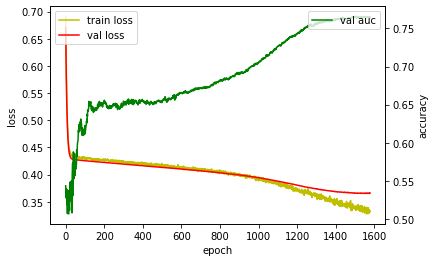

In [46]:
plt_show(hist)

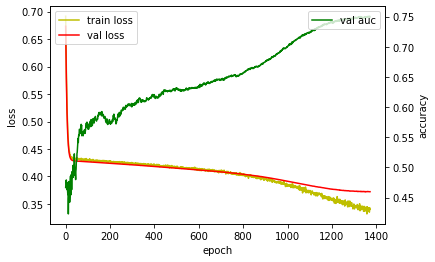

In [47]:
plt_show(hist2)

In [49]:
model.evaluate(train_input,train_label)

5100/5100 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 36us/step


[0.31128618880814196, 0.8698626756668091]

In [48]:
model2.evaluate(train_input2,train_label)

5100/5100 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - 0s 35us/step


[0.3199136156428094, 0.8634520769119263]

In [54]:
def chk(test):
    cnt=0
    for i in range(test.shape[0]):
        if x_test.iloc[i].applied == test.iloc[i].pred:
            cnt+=1
    print(cnt/test.shape[0])

In [55]:
#첫번째 모델 평가

test_input = [test_category[:,i] for i in range(test_category.shape[1])]+[test_matchTags]+[test_continue]
test_pred = model.predict(test_input)
pred = pd.DataFrame(test_pred)
pred.columns=['pred']
pred['pred'] = pred['pred'].apply(lambda x: 1 if x>=.5 else 0)

chk(pred)
pred.to_csv('DeepFM_pred.csv',index=False)

0.8711111111111111


In [56]:
#두번째 모델 평가

test_input2 = [test_category[:,i] for i in range(test_category.shape[1])]+[test_continue]
test_pred2 = model2.predict(test_input2)
pred = pd.DataFrame(test_pred2)
pred.columns=['pred']
pred['pred'] = pred['pred'].apply(lambda x: 1 if x>=.5 else 0)
cnt = 0

chk(pred)
pred.to_csv('DeepFM_pred2.csv',index=False)

0.8655555555555555


In [37]:
import gc
gc.collect()

80

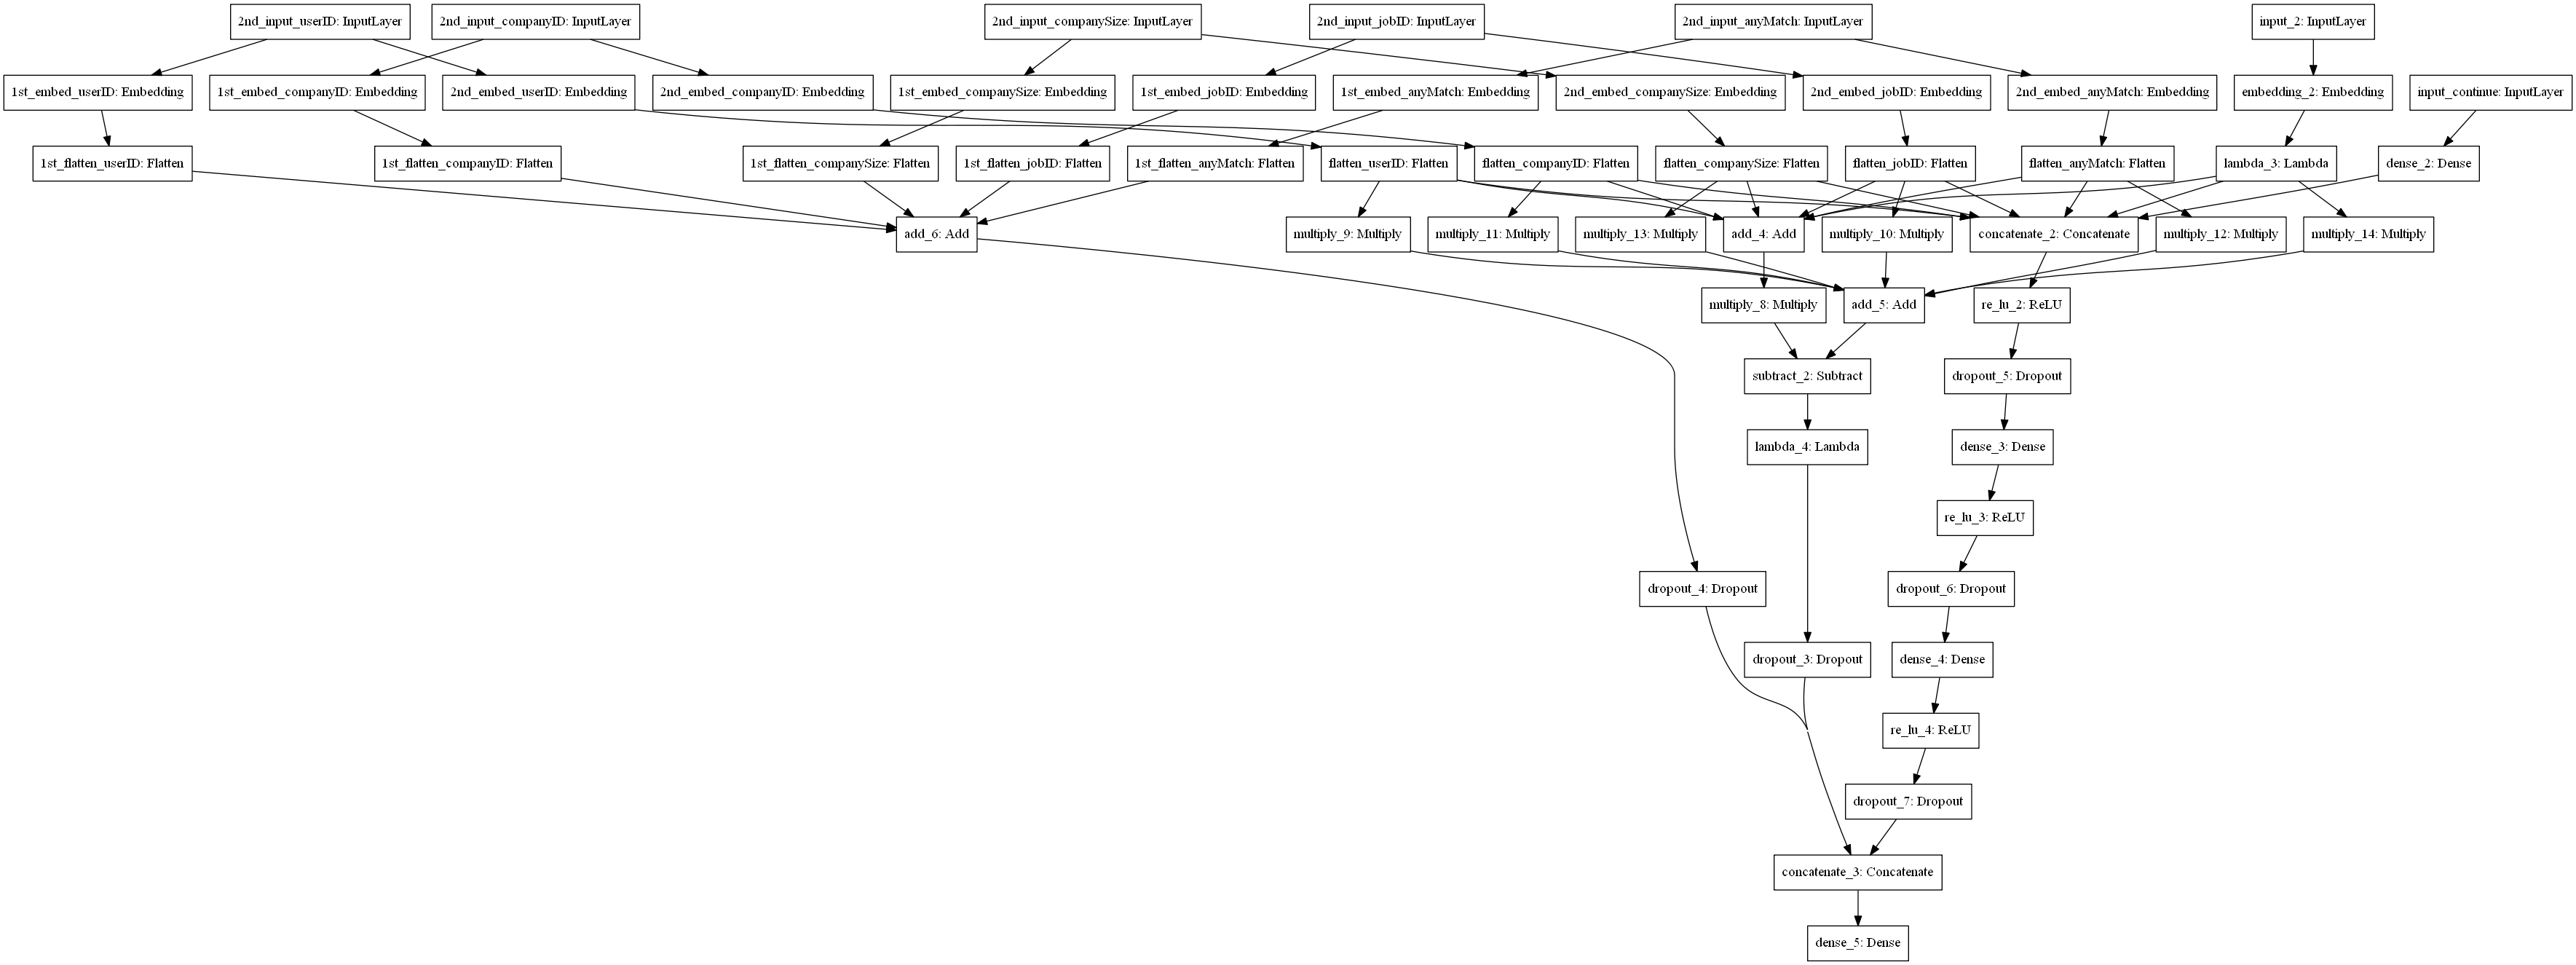

In [38]:
keras.utils.vis_utils.pydot = pydot
plot_model(model,to_file='model.png')